The goal of the home price regression competition is to predict the sale price of the home based on information about the home. The competition is described at https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

The data is described in data_predictions.txt.

Import the necessary packages

In [1163]:
# Core
import numpy as np
import pandas as pd
import os
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

# Tree-based model
import xgboost as xgb

Set the random seed to 42 to ensure repeatability.

In [1164]:
RANDOM_STATE = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
seed_everything(seed=RANDOM_STATE)

Set the location of the data files based on running on local machine or kaggle website.

In [1165]:
KAGGLE = False

In [1166]:
if KAGGLE:
    train_csv = ''
    test_csv = ''
else:
    train_csv = '/Users/roberthennessy/Documents/machine learning/house price/data/train.csv'
    test_csv = '/Users/roberthennessy/Documents/machine learning/house price/data/test.csv'
    

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [1167]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


Separate the data into X and y.

Create list of columns that are numeric or categorical.

In [1168]:
cat_cols = train_df.drop(columns=['SalePrice', 'Id']).select_dtypes(include=["object"]).columns.tolist()
num_cols = train_df.drop(columns=['SalePrice', 'Id']).select_dtypes(exclude=["object"]).columns.tolist()

len(cat_cols), len(num_cols)

(43, 36)

MSSubClass is a categorical column which is misidentified as numerical column.

In [1169]:
cat_cols.append('MSSubClass')
num_cols.remove('MSSubClass')

Remove the Id column

In [1170]:
train_df.drop(columns=['Id'], inplace=True)

Check for duplicated rows in the train and test dataset.

In [1171]:
print("Duplicated Rows in Train:",train_df.duplicated().sum())
print("Duplicated Rows in Test:",test_df.duplicated().sum())

Duplicated Rows in Train: 0
Duplicated Rows in Test: 0


There are no duplicated rows in the train and test set.

Check for missing values in the data.

In [1172]:
def missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total / len(df)
    missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    # Filter columns that actually have missing values.
    return missing_data[missing_data["Total"] > 0]

print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
MasVnrType      872  0.597260
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtCond         37  0.025342
BsmtQual         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
Electrical        1  0.000685
Missing data in test_df:
              Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
MasVnrType      894  0.612748
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageFinish     78  0.053461
GarageCond       78

There are some columns that have a lot of NaNs. However, for some columns, NaNs are expected. For example, pool quality is Na if no pool exists. For those rows, Nas should not be imputed.

In [1173]:
rows_na_expected = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [1174]:
train_df.loc[train_df['PoolArea'] == 0, 'PoolQC'] = 'None'
test_df.loc[test_df['PoolArea'] == 0, 'PoolQC'] = 'None'

train_df.loc[train_df['MiscVal']==0, 'MiscFeature'] = 'None'
test_df.loc[test_df['MiscVal']==0, 'MiscFeature'] = 'None'

train_df.loc[train_df['Alley'].isna(), 'Alley'] = 'None'
test_df.loc[test_df['Alley'].isna(), 'Alley'] = 'None'

train_df.loc[train_df['Fence'].isna(), 'Fence'] = 'None'
test_df.loc[test_df['Fence'].isna(), 'Fence'] = 'None'


train_df.loc[train_df['Fireplaces']==0, 'FireplaceQu'] = 'None'
test_df.loc[test_df['Fireplaces']==0, 'FireplaceQu'] = 'None'

train_df.loc[train_df['GarageArea']==0, ['GarageFinish', 'GarageType','GarageQual',
                                         'GarageCond']] = 'None'
test_df.loc[test_df['GarageArea']==0, ['GarageFinish', 'GarageType','GarageQual',
                                       'GarageCond']] = 'None'

train_df.loc[train_df['BsmtFinSF1'] == 0, 'BsmtFinType1'] = 'None'
test_df.loc[test_df['BsmtFinSF1'] == 0, 'BsmtFinType1'] = 'None'

"""
train_df.loc[train_df['BsmtFinSF2'] == 0, 'BsmtFinType2'] = 'None'
test_df.loc[test_df['BsmtFinSF2'] == 0, 'BsmtFinType2'] = 'None'

train_df.loc[train_df['MasVnrArea'] == 0, 'MasVnrType'] = 'None'
test_df.loc[test_df['MasVnrArea'] == 0, 'MasVnrType'] = 'None'
"""

train_df.loc[train_df['TotalBsmtSF'] == 0, ['BsmtCond', 'BsmtQual', 'BsmtExposure']] = 'None'
test_df.loc[test_df['TotalBsmtSF'] == 0, ['BsmtCond', 'BsmtQual', 'BsmtExposure']] = 'None'




In [1175]:
print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
MasVnrType      872  0.597260
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
BsmtFinType2     38  0.026027
MasVnrArea        8  0.005479
BsmtExposure      1  0.000685
Electrical        1  0.000685
Missing data in test_df:
              Total   Percent
MasVnrType      894  0.612748
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
BsmtFinType2     42  0.028787
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtCond          4  0.002742
BsmtQual          3  0.002056
BsmtExposure      3  0.002056
PoolQC            3  0.002056
Utilities         2  0.001371
Functional        2  0.001371
BsmtFullBath      2  0.001371
GarageCond        2  0.001371
GarageQual        2  0.001371
GarageFinish      2  0.001371
BsmtHalfBath      2  0.001371
BsmtFinSF2        1  0.000685
BsmtUnfSF         1  0.000685
BsmtFinSF1        1  0.000685
BsmtFinType1      1  0.000685
TotalBsmtSF       1  0.000685
KitchenQual       1

There are four columns in the train dataset that have missing values: MasVnrType, LotFrontage, GarageYrBl, MasVnrArea and Electricl. Looking at data description, MasVnrType is categorical and uses None to indicate no masonry veneer. Therefore, this column will not be imputed. LotFrontage,  GarageYrBlt and MasVnrArea are numerical columns and will need to be imputed.

There are 19 columns in the test dataset that have missing values: <br>
MasVnrType       0.612748 - This column will not be imputed because it is categorical and none is                           a valid value. <br>
LotFrontage      0.155586 - This column will be imputed using the median of the column. <br>
GarageYrBlt      0.053461 - This column will be imputed using the YearBuilt. <br>
MasVnrArea       0.010281 - This column will be imputed using the median of the column. <br>
Electrical        0.002742 - This column will be imputed using the mode of the column. <br>
MSZoning         0.002742 - This column will be imputed using the mode of the column. <br>
BsmtFullBath     0.001371 - This column will be imputed using the mode of the column because
                            the values are discrete. <br>
BsmtHalfBath     0.001371 - This column will be imputed using the mode of the column because
                            the values are discrete. <br>
Utilities        0.001371 - This column will be imputed using the mode of the column. <br>
Functional       0.001371 - This column will be imputed using the mode of the column. <br>
BsmtFinSF2       0.000685 - This column will be imputed using the median of the column. <br>
GarageArea       0.000685 - This column will be imputed using the median of the column. <br>
Exterior1st      0.000685 - This column will be imputed using the mode of the column. <br>
KitchenQual      0.000685 - This column will be imputed using the mode of the column. <br>
GarageCars       0.000685 - This column will be imputed using the mode of the column. <br>
Exterior2nd      0.000685 - This column will be imputed using the mode of the column. <br>
BsmtFinSF1       0.000685 - This column will be imputed using the median of the column. <br>
BsmtUnfSF        0.000685 - This column will be imputed using the median of the column. <br>
TotalBsmtSF      0.000685 - This column will be imputed using the median of the column. <br>
SaleType         0.000685 - This column will be imputed using the mode of the column. <br>


In [1176]:
print(train_df['MasVnrType'].value_counts(dropna=False))

MasVnrType
NaN        872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64


Check PoolQC due to the high number of NaNs

In [1177]:
print(train_df[train_df['PoolArea'] == 0]['PoolQC'].value_counts(dropna=False))
print(train_df[train_df['PoolArea'] != 0]['PoolQC'].value_counts(dropna=False))
print(len(train_df[train_df['PoolArea'] != 0]))

PoolQC
None    1453
Name: count, dtype: int64
PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64
7


High number of NaNs is due to very few houses having a pool.

In most cases, the garage and house should be built at the same time. Let's check if that is true in the data.

<Axes: >

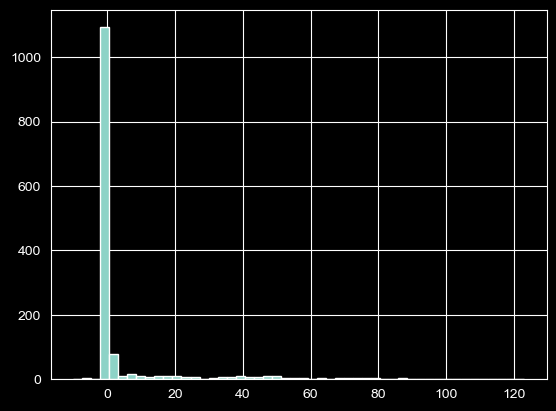

In [1178]:
dif_gar_house_built = train_df['GarageYrBlt'] - train_df['YearBuilt']
dif_gar_house_built.hist(bins=50)

Assume that the lots are square so that lot frontage is the sqrt of the lot area.

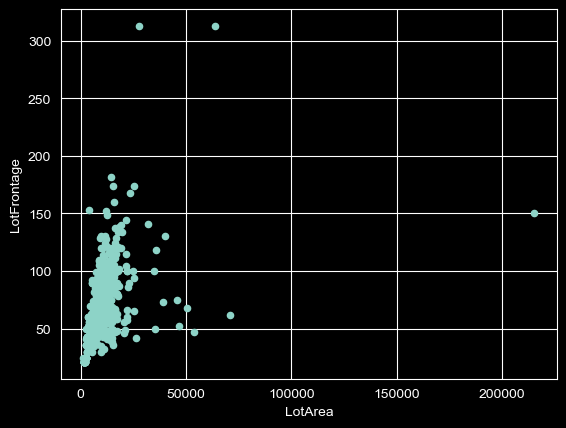

count    1201.000000
mean      -26.499856
std        22.045553
min      -313.945040
25%       -32.433760
50%       -24.852814
75%       -18.077641
max       146.717109
dtype: float64


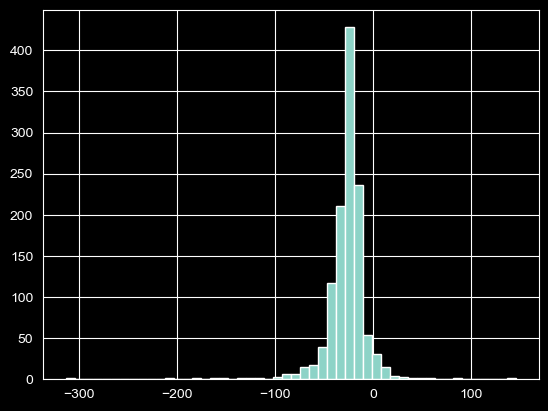

In [1179]:
train_df.plot.scatter(x='LotArea', y='LotFrontage')
plt.show()

lot_front_area = train_df['LotFrontage'] - np.sqrt(train_df['LotArea'])
lot_front_area.hist(bins=50)
print(lot_front_area.describe())
mean_lot_frontage_shift = lot_front_area.mean()

For missing GarageYrBlt use YearBuilt. Fill electrical with the mode. Fill in lot frontage with the simple model.

In [1180]:
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['YearBuilt'])
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(np.sqrt(train_df['LotArea']) + mean_lot_frontage_shift)

Impute the missing values in test_df by using the median or the mode of the train_df.

In [1181]:
test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(test_df['YearBuilt'])
test_df['Electrical'] = test_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(np.sqrt(test_df['LotArea']) + mean_lot_frontage_shift)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(train_df['MasVnrArea'].median())
test_df['MSZoning'] = test_df['MSZoning'].fillna(train_df['MSZoning'].mode()[0])
test_df['BsmtFullBath'] = test_df['BsmtFullBath'].fillna(train_df['BsmtFullBath'].mode()[0])
test_df['BsmtHalfBath'] = test_df['BsmtHalfBath'].fillna(train_df['BsmtHalfBath'].mode()[0])
test_df['Utilities'] = test_df['Utilities'].fillna(train_df['Utilities'].mode()[0])
test_df['Functional'] = test_df['Functional'].fillna(train_df['Functional'].mode()[0])
test_df['BsmtFinSF2'] = test_df['BsmtFinSF2'].fillna(train_df['BsmtFinSF2'].median())
test_df['GarageArea'] = test_df['GarageArea'].fillna(train_df['GarageArea'].median())
test_df['Exterior1st'] = test_df['Exterior1st'].fillna(train_df['Exterior1st'].mode()[0])
test_df['KitchenQual'] = test_df['KitchenQual'].fillna(train_df['KitchenQual'].mode()[0])
test_df['GarageCars'] = test_df['GarageCars'].fillna(train_df['GarageCars'].mode()[0])
test_df['Exterior2nd'] = test_df['Exterior2nd'].fillna(train_df['Exterior2nd'].mode()[0])
test_df['BsmtFinSF1'] = test_df['BsmtFinSF1'].fillna(train_df['BsmtFinSF1'].median())
test_df['BsmtUnfSF'] = test_df['BsmtUnfSF'].fillna(train_df['BsmtUnfSF'].median())
test_df['TotalBsmtSF'] = test_df['TotalBsmtSF'].fillna(train_df['TotalBsmtSF'].median())
test_df['SaleType'] = test_df['SaleType'].fillna(train_df['SaleType'].mode()[0])
test_df['MasVnrType'] = test_df['MasVnrType'].fillna(train_df['MasVnrType'].mode()[0])
test_df['BsmtCond'] = test_df['BsmtCond'].fillna(train_df['BsmtCond'].mode()[0])
test_df['BsmtQual'] = test_df['BsmtQual'].fillna(train_df['BsmtQual'].mode()[0])
test_df['BsmtExposure'] = test_df['BsmtExposure'].fillna(train_df['BsmtExposure'].mode()[0])
test_df['PoolQC'] = test_df['PoolQC'].fillna(train_df['PoolQC'].mode()[0])
test_df['GarageFinish'] = test_df['GarageFinish'].fillna(train_df['GarageFinish'].mode()[0])
test_df['GarageQual'] = test_df['GarageQual'].fillna(train_df['GarageQual'].mode()[0])
test_df['GarageCond'] = test_df['GarageCond'].fillna(train_df['GarageCond'].mode()[0])
test_df['BsmtFinType2'] = test_df['BsmtFinType2'].fillna(train_df['BsmtFinType2'].mode()[0])
test_df['BsmtFinType1'] = test_df['BsmtFinType1'].fillna(train_df['BsmtFinType1'].mode()[0])
test_df['MiscFeature'] = test_df['MiscFeature'].fillna(train_df['MiscFeature'].mode()[0])

In [1182]:
train_df['MasVnrType'] = train_df['MasVnrType'].fillna(train_df['MasVnrType'].mode()[0])
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].median())
train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna(train_df['BsmtExposure'].mode()[0])
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna(train_df['BsmtFinType2'].mode()[0])

In [1183]:
print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
Empty DataFrame
Columns: [Total, Percent]
Index: []
Missing data in test_df:
Empty DataFrame
Columns: [Total, Percent]
Index: []


Function to describe the numerical columns. Description countains the count, mean std, min, percnetiles and max. I also added the percent missing.

Create some new features.

In [1184]:
train_df['AgeHouse'] = train_df['YearBuilt'] - train_df['YrSold']
test_df['AgeHouse'] = test_df['YearBuilt'] - test_df['YrSold']

train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

train_df['TotalBath'] = train_df['BsmtFullBath'] + train_df['BsmtHalfBath'] + train_df['FullBath'] + train_df['HalfBath']
test_df['TotalBath'] = test_df['BsmtFullBath'] + test_df['BsmtHalfBath'] + test_df['FullBath'] + test_df['HalfBath']

In [1185]:
def find_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers

In [1186]:
def describe_col(col):
    train_describe = train_df[col].describe()
    train_describe['per missing'] = train_df[col].isnull().sum()/len(train_df)
    train_describe['numb outliers'] = find_outliers_iqr(train_df, col).shape[0]
    train_describe.name = 'train_df'
    test_describe = test_df[col].describe()
    test_describe['per missing'] = test_df[col].isnull().sum()/len(test_df)
    test_describe['numb outliers'] = find_outliers_iqr(test_df, col).shape[0]
    test_describe.name = 'test_df'
    return pd.concat([train_describe, test_describe], axis=1)
print(num_cols[0])
print(describe_col(num_cols[0]))

LotFrontage
                  train_df      test_df
count          1460.000000  1459.000000
mean             71.943194    69.978904
std              28.159563    23.242088
min              17.929864    12.653688
25%              60.000000    60.000000
50%              70.000000    69.000000
75%              82.000000    80.355053
max             379.283337   211.407689
per missing       0.000000     0.000000
numb outliers   109.000000   134.000000


Functions to plot different types of histograms.

Function to determine if outliers exist in the data

In [1187]:
def plot_overlaid_histograms(df1, df2, col, df1_label, df2_label, bins):
    # Plot overlaid histograms
    plt.hist(df1[col], bins=bins, alpha=0.7, label=df1_label, color='blue')
    plt.hist(df2[col], bins=bins, alpha=0.7, label=df2_label, color='orange')
    
    plt.title('Overlaid Histograms')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_multi_hist(df1, df2, col, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    axs[0].hist(df1[col], bins=bins, color='blue')
    axs[0].set_title(df1_label)
    axs[1].hist(df2[col], bins=bins, label=df2_label, color='orange')
    axs[1].set_title(df2_label)
    plt.show()

def plot_multi_hist2(df1, df2, col, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='blue', ax=axs[0], title=df1_label)
    df2[col].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='orange', ax=axs[1], title=df2_label)
    plt.show()

def plot_multi_bar(df1, df2, col, df1_label, df2_label):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col].value_counts().plot.bar(color='blue', ax=axs[0], title=df1_label)
    df2[col].value_counts().plot.bar(color='orange', ax=axs[1], title=df2_label)
    plt.show()

LotFrontage
                  train_df      test_df
count          1460.000000  1459.000000
mean             71.943194    69.978904
std              28.159563    23.242088
min              17.929864    12.653688
25%              60.000000    60.000000
50%              70.000000    69.000000
75%              82.000000    80.355053
max             379.283337   211.407689
per missing       0.000000     0.000000
numb outliers   109.000000   134.000000


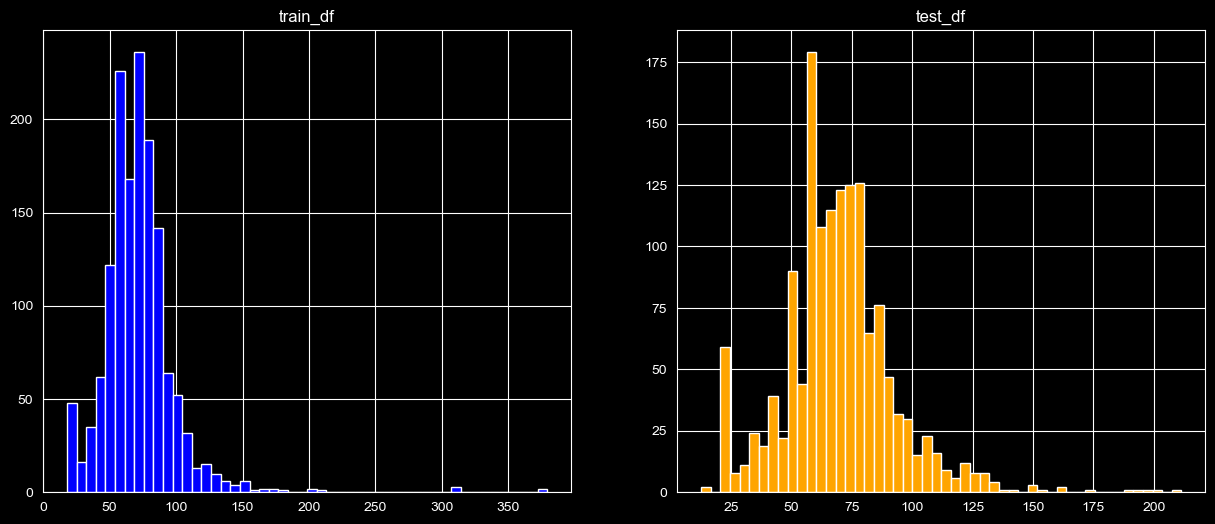

LotArea
                    train_df       test_df
count            1460.000000   1459.000000
mean            10516.828082   9819.161069
std              9981.264932   4955.517327
min              1300.000000   1470.000000
25%              7553.500000   7391.000000
50%              9478.500000   9399.000000
75%             11601.500000  11517.500000
max            215245.000000  56600.000000
per missing         0.000000      0.000000
numb outliers      69.000000     60.000000


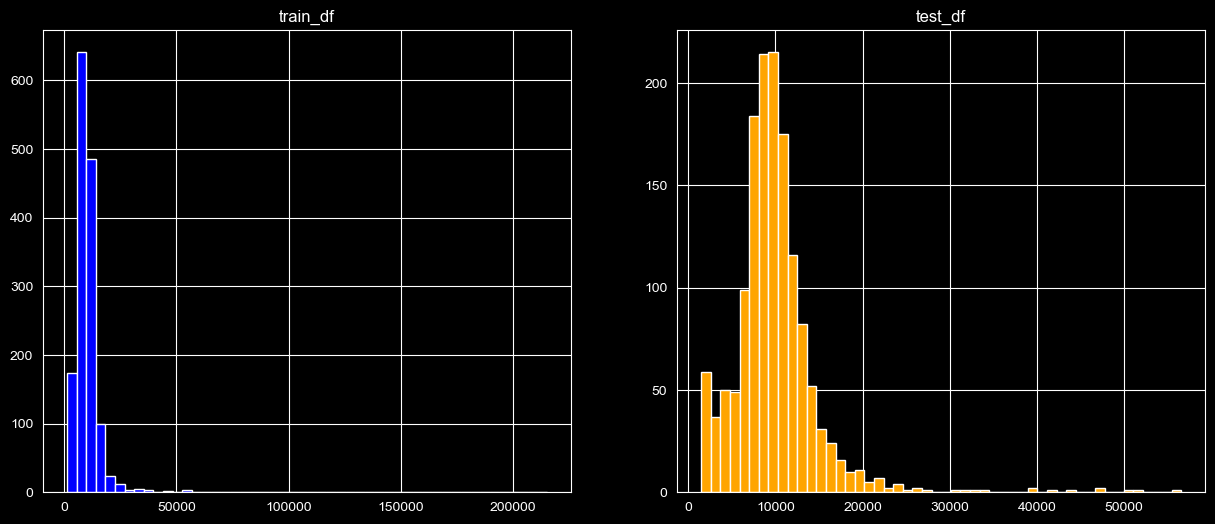

OverallQual
                  train_df      test_df
count          1460.000000  1459.000000
mean              6.099315     6.078821
std               1.382997     1.436812
min               1.000000     1.000000
25%               5.000000     5.000000
50%               6.000000     6.000000
75%               7.000000     7.000000
max              10.000000    10.000000
per missing       0.000000     0.000000
numb outliers     2.000000     2.000000


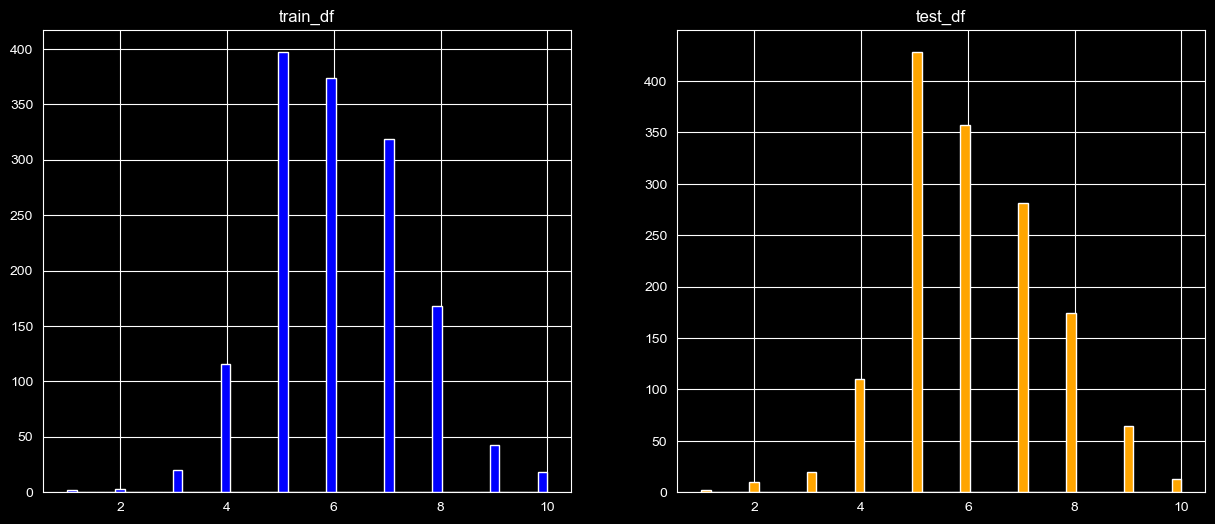

OverallCond
                  train_df      test_df
count          1460.000000  1459.000000
mean              5.575342     5.553804
std               1.112799     1.113740
min               1.000000     1.000000
25%               5.000000     5.000000
50%               5.000000     5.000000
75%               6.000000     6.000000
max               9.000000     9.000000
per missing       0.000000     0.000000
numb outliers   125.000000   127.000000


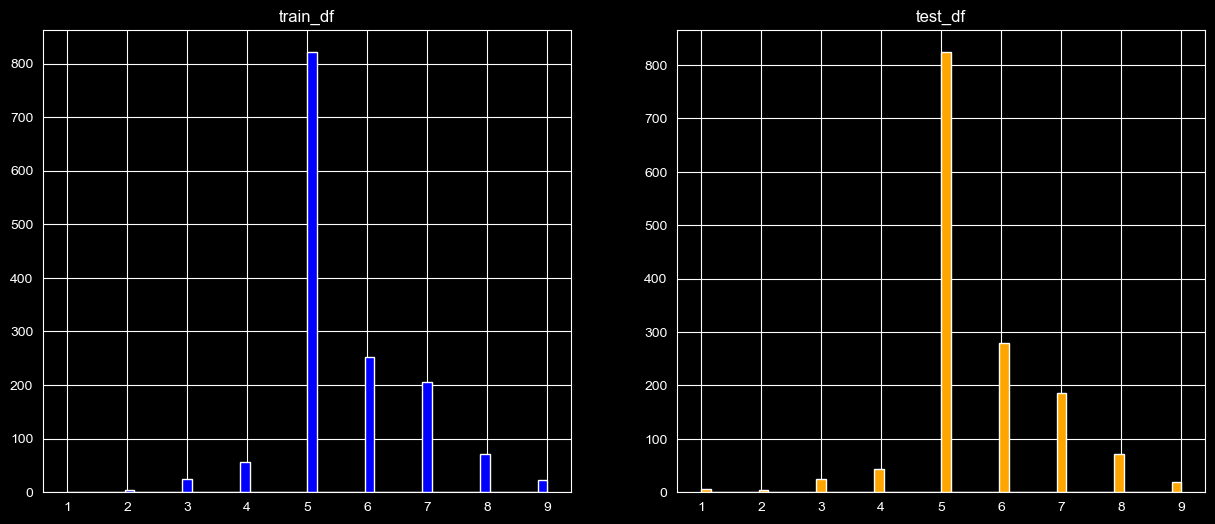

YearBuilt
                  train_df      test_df
count          1460.000000  1459.000000
mean           1971.267808  1971.357779
std              30.202904    30.390071
min            1872.000000  1879.000000
25%            1954.000000  1953.000000
50%            1973.000000  1973.000000
75%            2000.000000  2001.000000
max            2010.000000  2010.000000
per missing       0.000000     0.000000
numb outliers     7.000000     2.000000


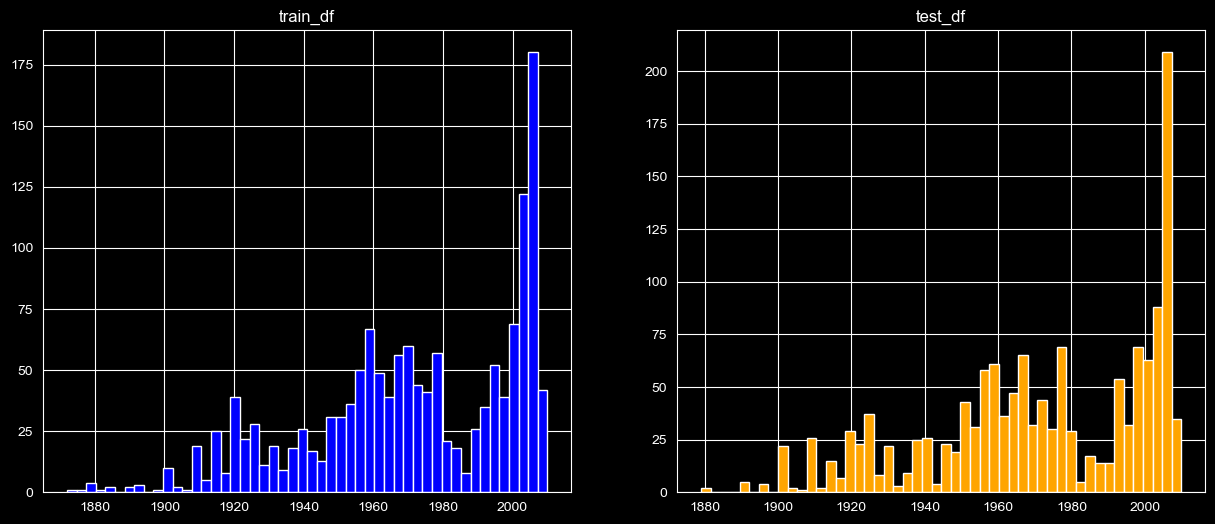

YearRemodAdd
                  train_df      test_df
count          1460.000000  1459.000000
mean           1984.865753  1983.662783
std              20.645407    21.130467
min            1950.000000  1950.000000
25%            1967.000000  1963.000000
50%            1994.000000  1992.000000
75%            2004.000000  2004.000000
max            2010.000000  2010.000000
per missing       0.000000     0.000000
numb outliers     0.000000     0.000000


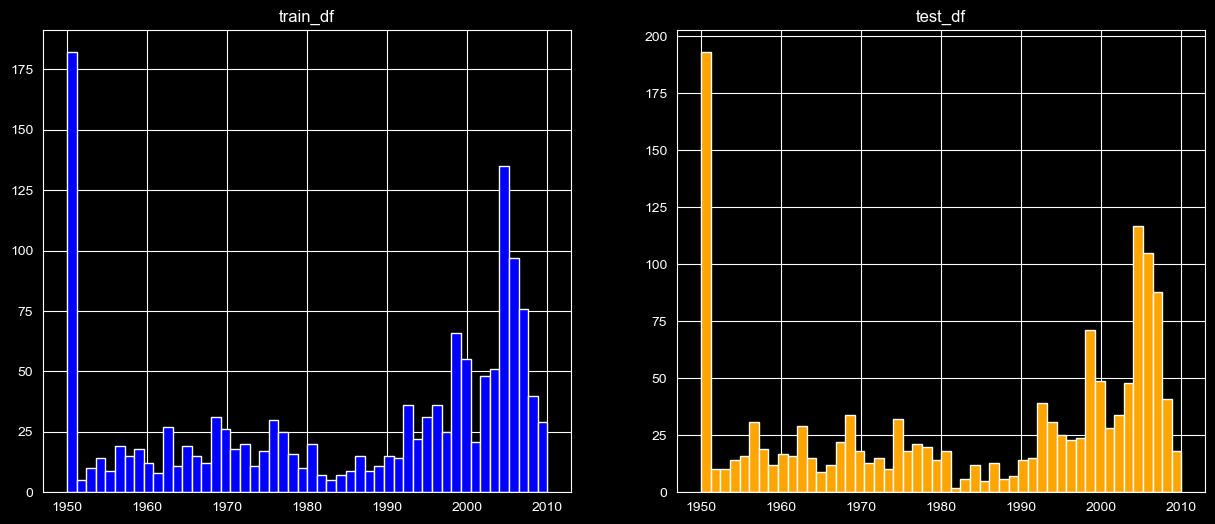

MasVnrArea
                  train_df      test_df
count          1460.000000  1459.000000
mean            103.117123    99.673749
std             180.731373   177.001792
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%             164.250000   162.000000
max            1600.000000  1290.000000
per missing       0.000000     0.000000
numb outliers    98.000000   104.000000


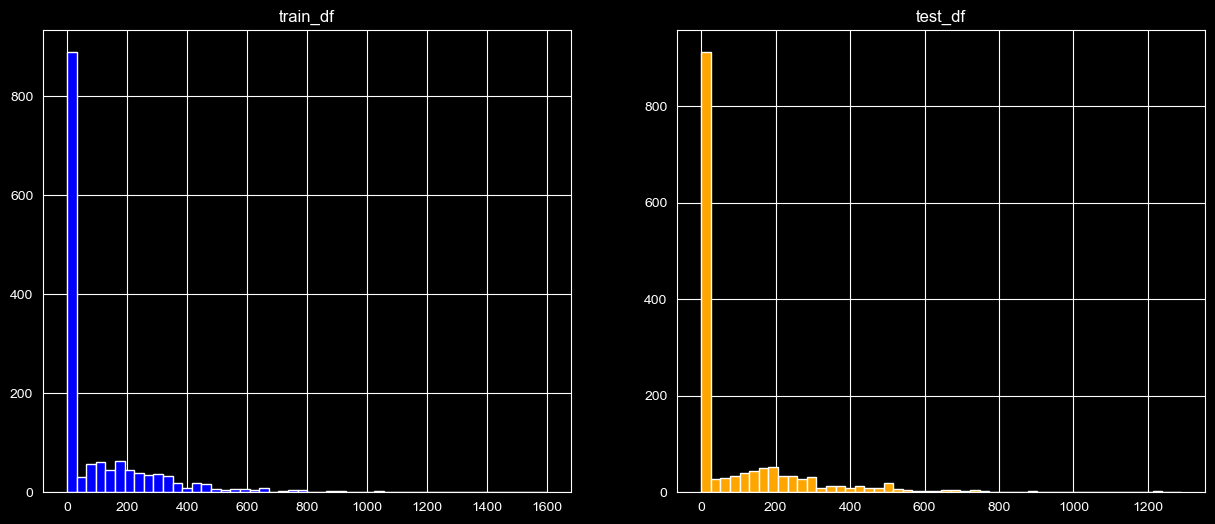

BsmtFinSF1
                  train_df      test_df
count          1460.000000  1459.000000
mean            443.639726   439.165524
std             456.098091   455.114224
min               0.000000     0.000000
25%               0.000000     0.000000
50%             383.500000   351.000000
75%             712.250000   752.000000
max            5644.000000  4010.000000
per missing       0.000000     0.000000
numb outliers     7.000000     8.000000


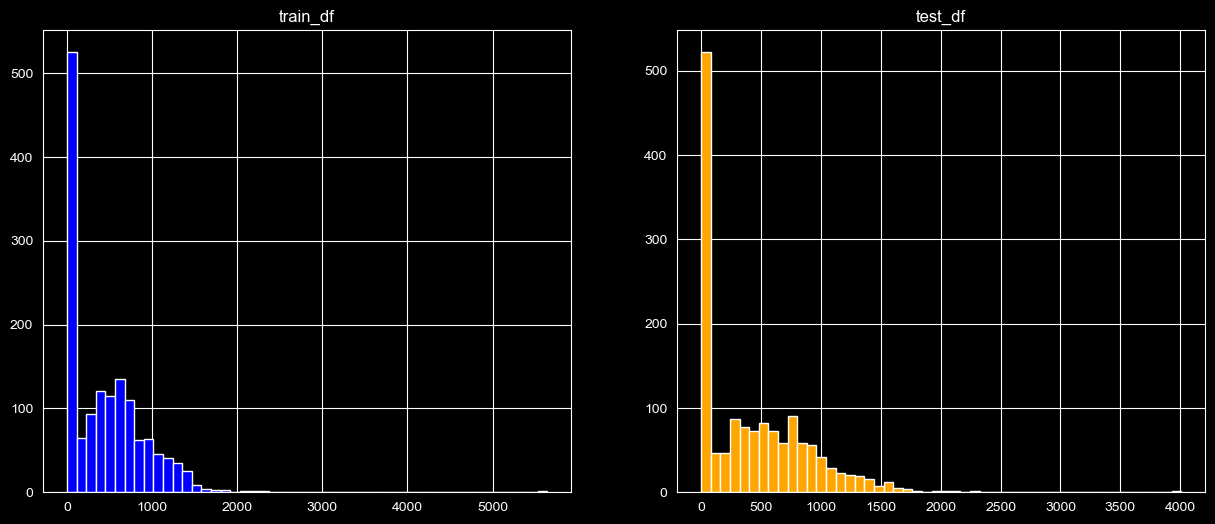

BsmtFinSF2
                  train_df      test_df
count          1460.000000  1459.000000
mean             46.549315    52.583276
std             161.319273   176.698671
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max            1474.000000  1526.000000
per missing       0.000000     0.000000
numb outliers   167.000000   180.000000


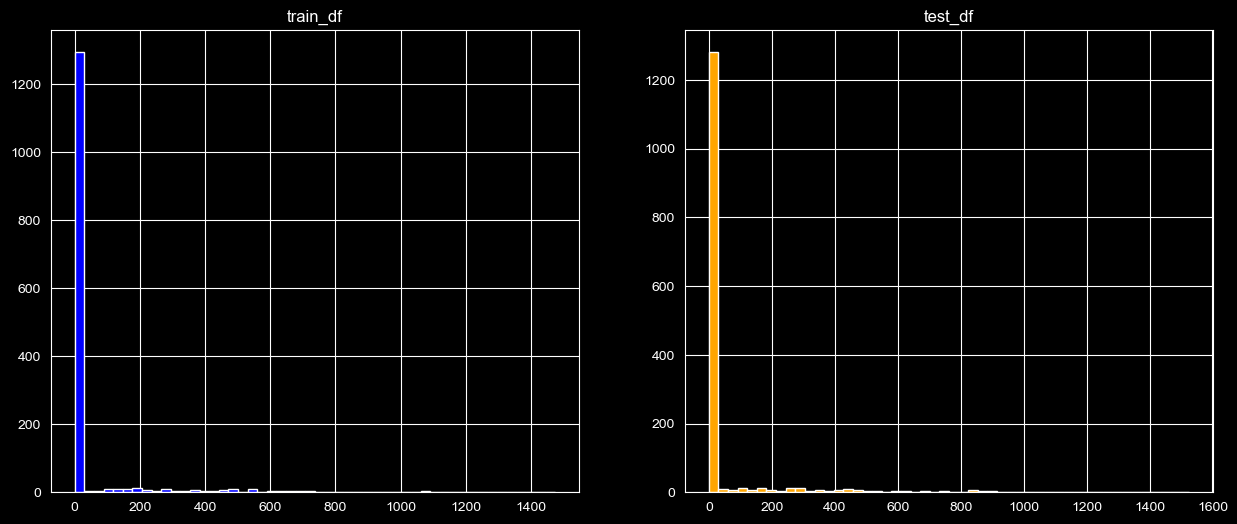

BsmtUnfSF
                  train_df      test_df
count          1460.000000  1459.000000
mean            567.240411   554.242289
std             441.866955   437.115132
min               0.000000     0.000000
25%             223.000000   219.500000
50%             477.500000   460.000000
75%             808.000000   797.500000
max            2336.000000  2140.000000
per missing       0.000000     0.000000
numb outliers    29.000000    26.000000


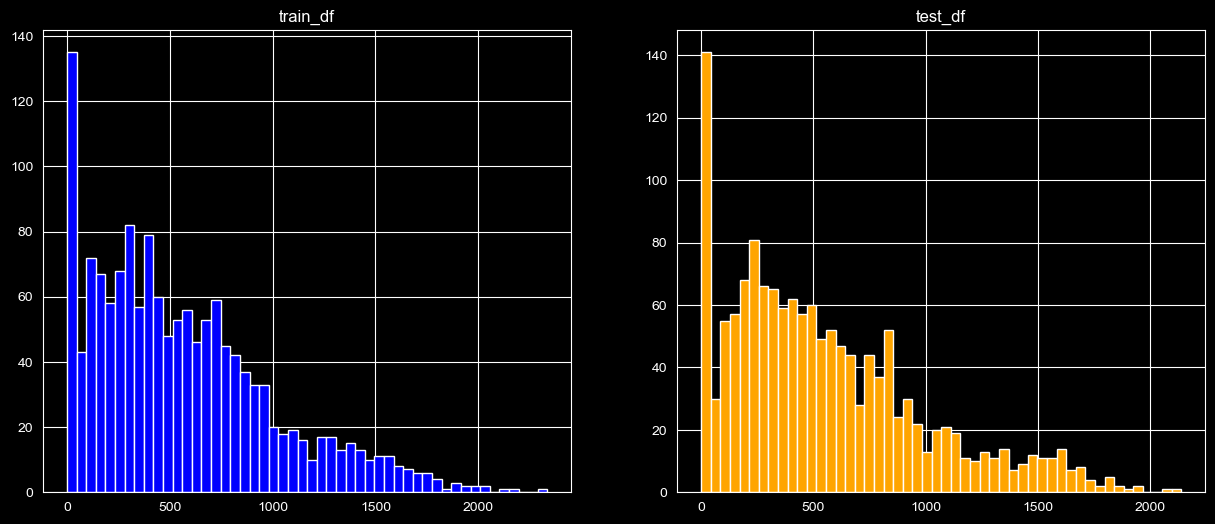

TotalBsmtSF
                  train_df      test_df
count          1460.000000  1459.000000
mean           1057.429452  1046.080535
std             438.705324   442.749021
min               0.000000     0.000000
25%             795.750000   784.000000
50%             991.500000   988.000000
75%            1298.250000  1304.000000
max            6110.000000  5095.000000
per missing       0.000000     0.000000
numb outliers    61.000000    61.000000


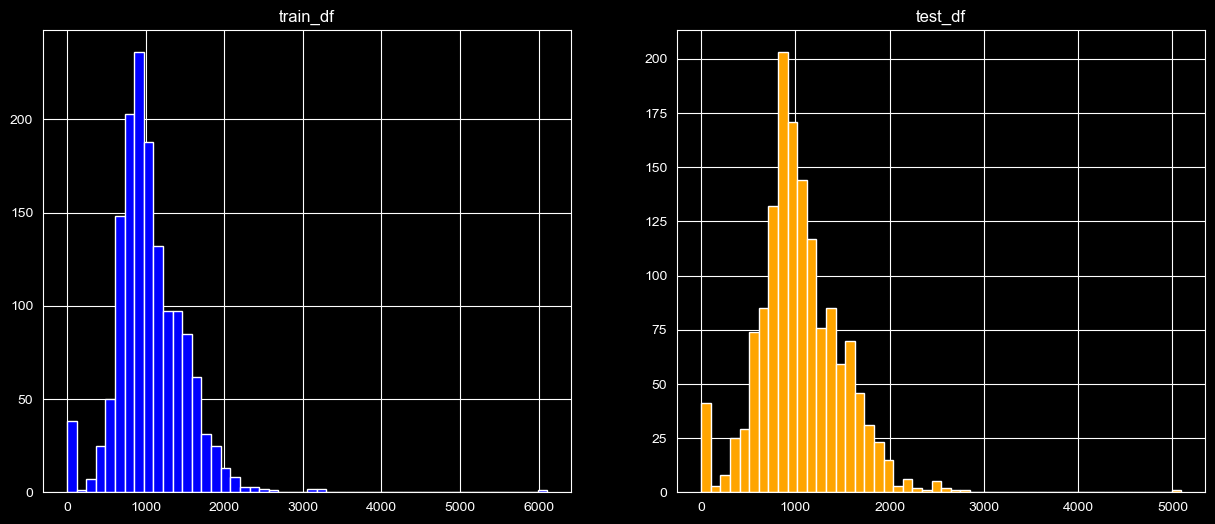

1stFlrSF
                  train_df      test_df
count          1460.000000  1459.000000
mean           1162.626712  1156.534613
std             386.587738   398.165820
min             334.000000   407.000000
25%             882.000000   873.500000
50%            1087.000000  1079.000000
75%            1391.250000  1382.500000
max            4692.000000  5095.000000
per missing       0.000000     0.000000
numb outliers    20.000000    23.000000


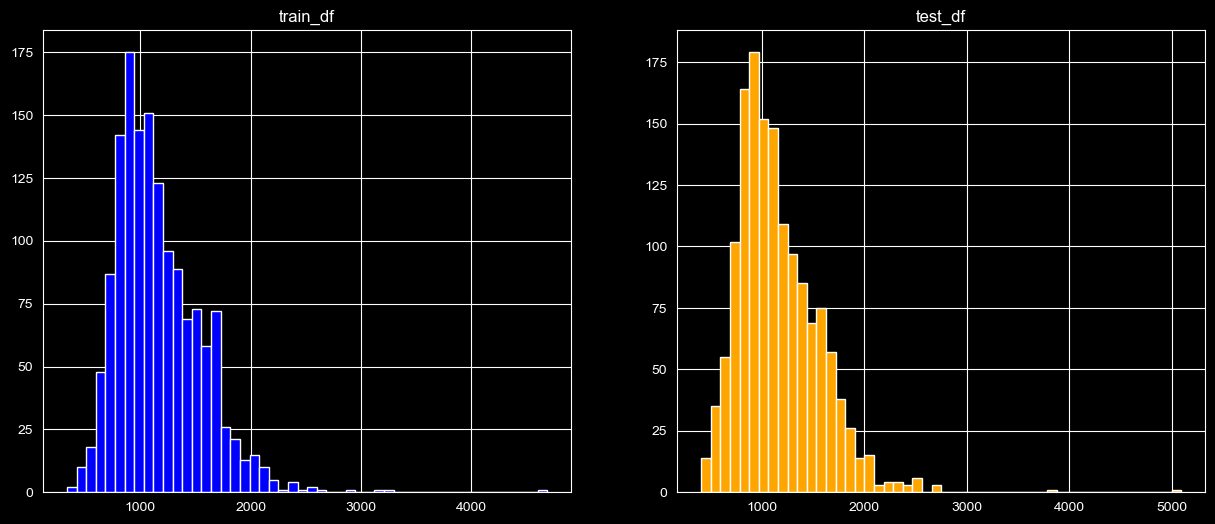

2ndFlrSF
                  train_df      test_df
count          1460.000000  1459.000000
mean            346.992466   325.967786
std             436.528436   420.610226
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%             728.000000   676.000000
max            2065.000000  1862.000000
per missing       0.000000     0.000000
numb outliers     2.000000     5.000000


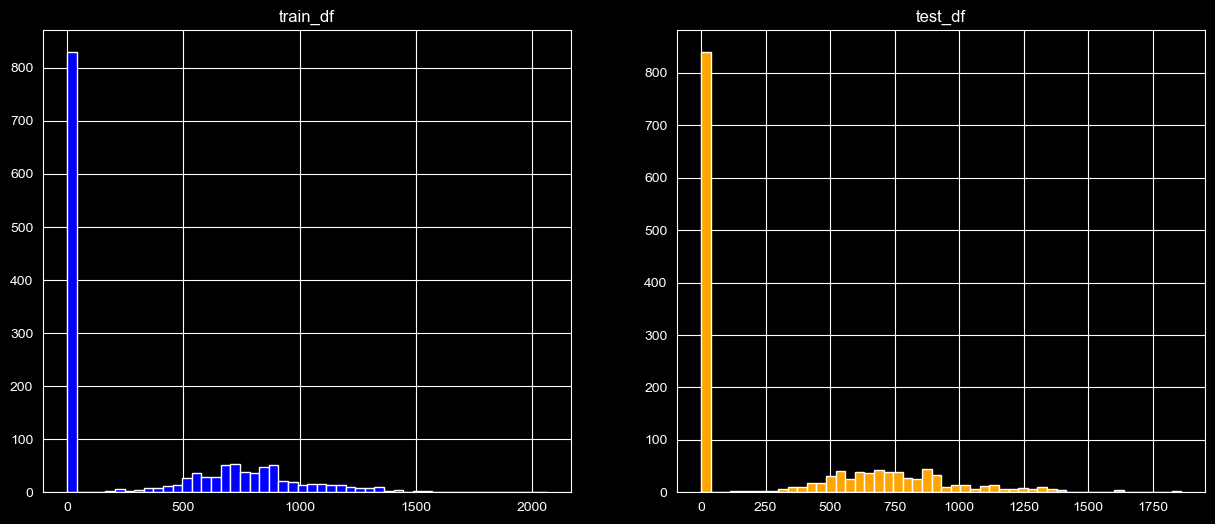

LowQualFinSF
                  train_df      test_df
count          1460.000000  1459.000000
mean              5.844521     3.543523
std              48.623081    44.043251
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             572.000000  1064.000000
per missing       0.000000     0.000000
numb outliers    26.000000    14.000000


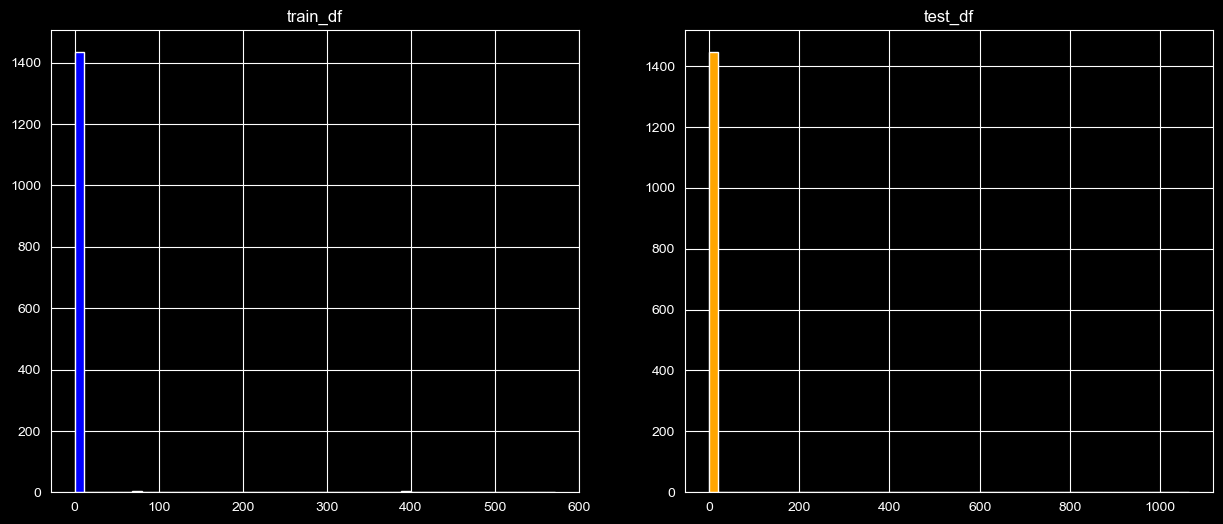

GrLivArea
                  train_df      test_df
count          1460.000000  1459.000000
mean           1515.463699  1486.045922
std             525.480383   485.566099
min             334.000000   407.000000
25%            1129.500000  1117.500000
50%            1464.000000  1432.000000
75%            1776.750000  1721.000000
max            5642.000000  5095.000000
per missing       0.000000     0.000000
numb outliers    31.000000    44.000000


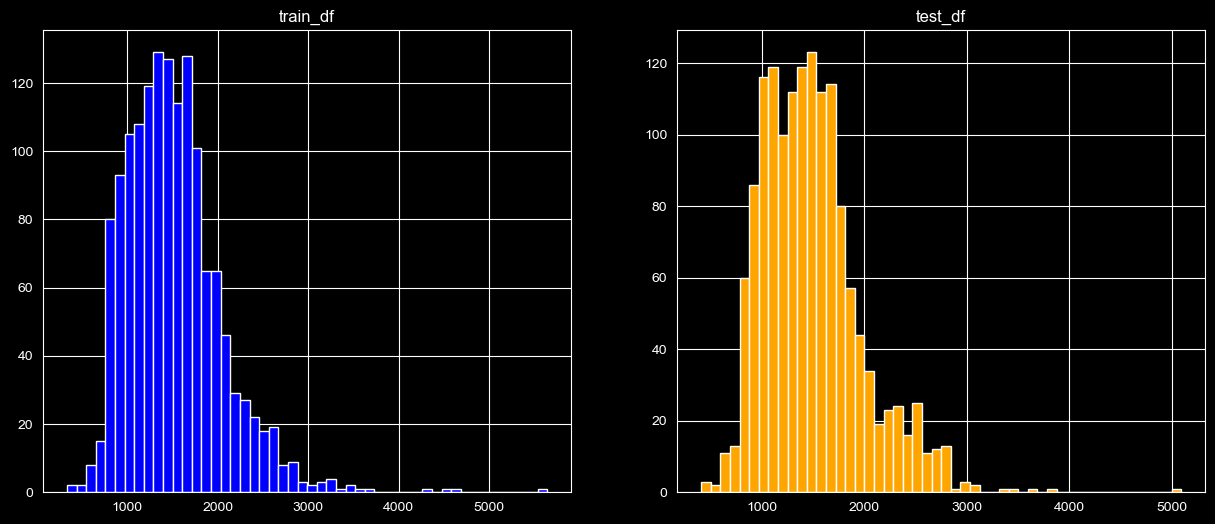

BsmtFullBath
                  train_df      test_df
count          1460.000000  1459.000000
mean              0.425342     0.433859
std               0.518911     0.530527
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               1.000000     1.000000
max               3.000000     3.000000
per missing       0.000000     0.000000
numb outliers     1.000000     1.000000


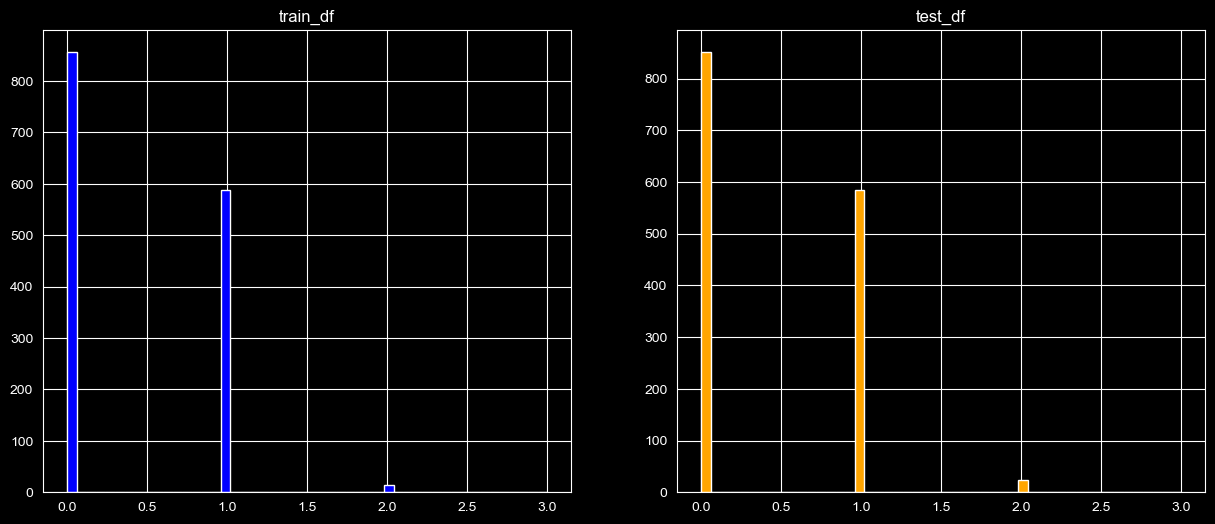

BsmtHalfBath
                  train_df      test_df
count          1460.000000  1459.000000
mean              0.057534     0.065113
std               0.238753     0.252307
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max               2.000000     2.000000
per missing       0.000000     0.000000
numb outliers    82.000000    93.000000


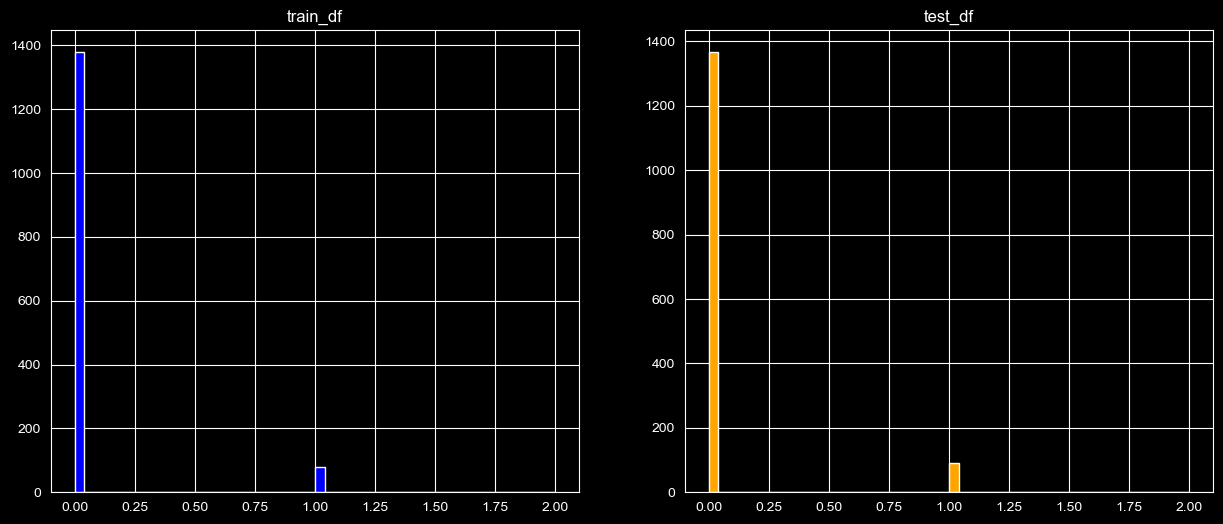

FullBath
                  train_df      test_df
count          1460.000000  1459.000000
mean              1.565068     1.570939
std               0.550916     0.555190
min               0.000000     0.000000
25%               1.000000     1.000000
50%               2.000000     2.000000
75%               2.000000     2.000000
max               3.000000     4.000000
per missing       0.000000     0.000000
numb outliers     0.000000     4.000000


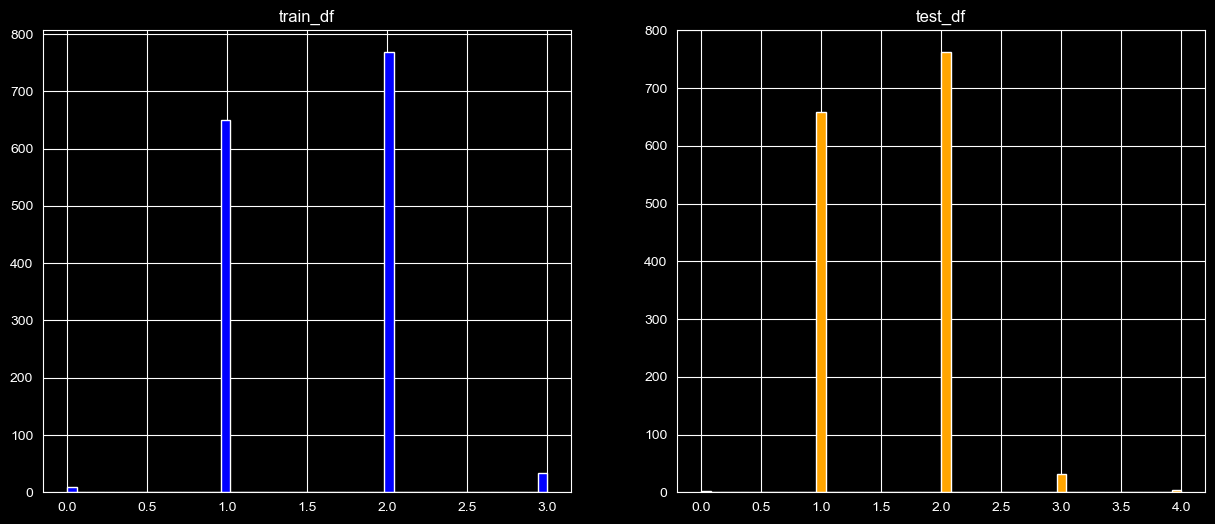

HalfBath
                  train_df      test_df
count          1460.000000  1459.000000
mean              0.382877     0.377656
std               0.502885     0.503017
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               1.000000     1.000000
max               2.000000     2.000000
per missing       0.000000     0.000000
numb outliers     0.000000     0.000000


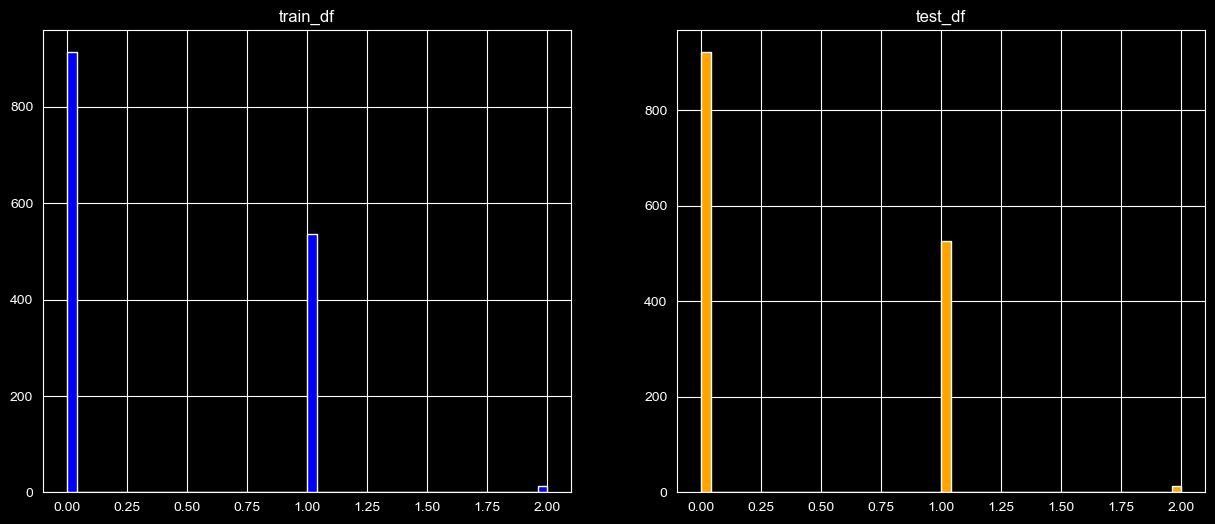

BedroomAbvGr
                  train_df      test_df
count          1460.000000  1459.000000
mean              2.866438     2.854010
std               0.815778     0.829788
min               0.000000     0.000000
25%               2.000000     2.000000
50%               3.000000     3.000000
75%               3.000000     3.000000
max               8.000000     6.000000
per missing       0.000000     0.000000
numb outliers    35.000000    43.000000


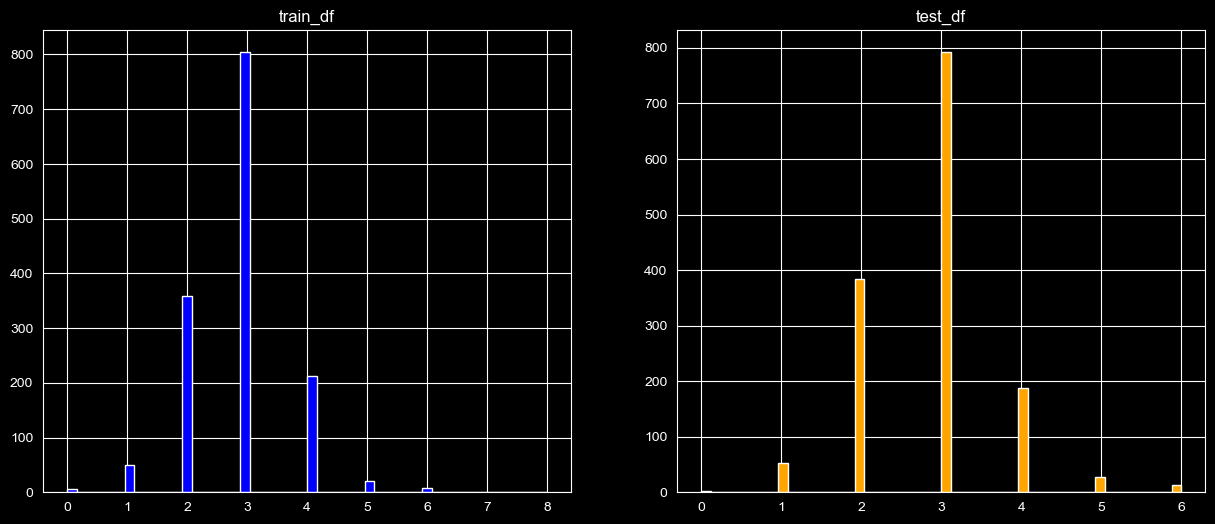

KitchenAbvGr
                  train_df      test_df
count          1460.000000  1459.000000
mean              1.046575     1.042495
std               0.220338     0.208472
min               0.000000     0.000000
25%               1.000000     1.000000
50%               1.000000     1.000000
75%               1.000000     1.000000
max               3.000000     2.000000
per missing       0.000000     0.000000
numb outliers    68.000000    66.000000


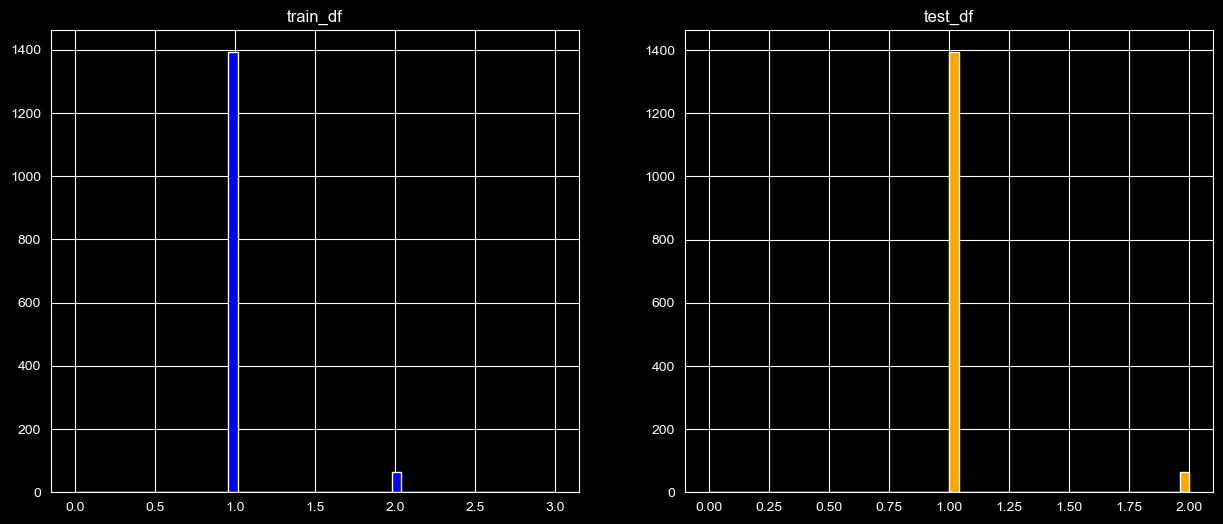

TotRmsAbvGrd
                  train_df      test_df
count          1460.000000  1459.000000
mean              6.517808     6.385195
std               1.625393     1.508895
min               2.000000     3.000000
25%               5.000000     5.000000
50%               6.000000     6.000000
75%               7.000000     7.000000
max              14.000000    15.000000
per missing       0.000000     0.000000
numb outliers    30.000000    21.000000


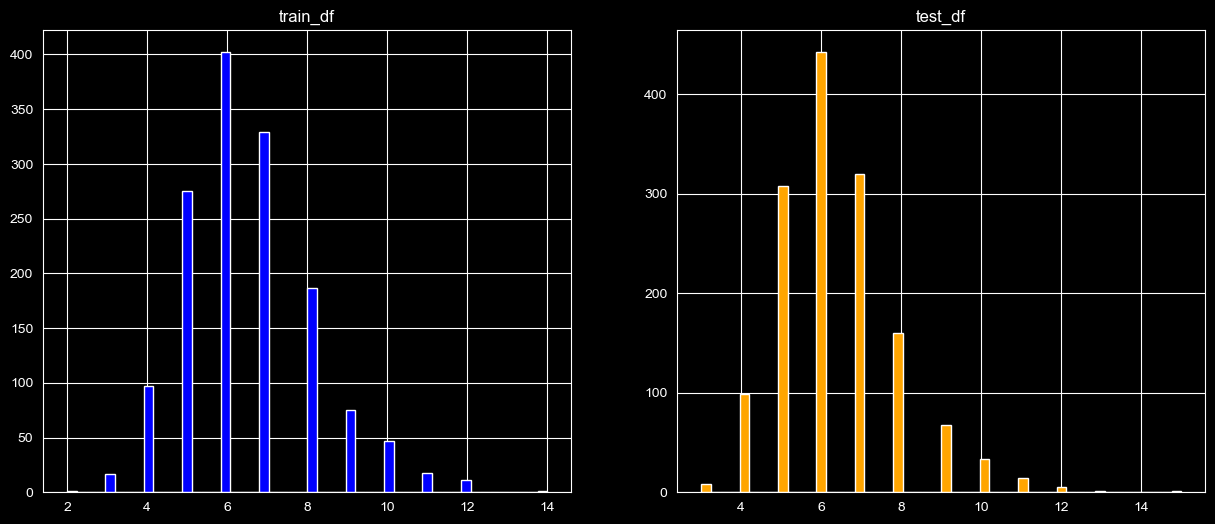

Fireplaces
                  train_df     test_df
count          1460.000000  1459.00000
mean              0.613014     0.58122
std               0.644666     0.64742
min               0.000000     0.00000
25%               0.000000     0.00000
50%               1.000000     0.00000
75%               1.000000     1.00000
max               3.000000     4.00000
per missing       0.000000     0.00000
numb outliers     5.000000     7.00000


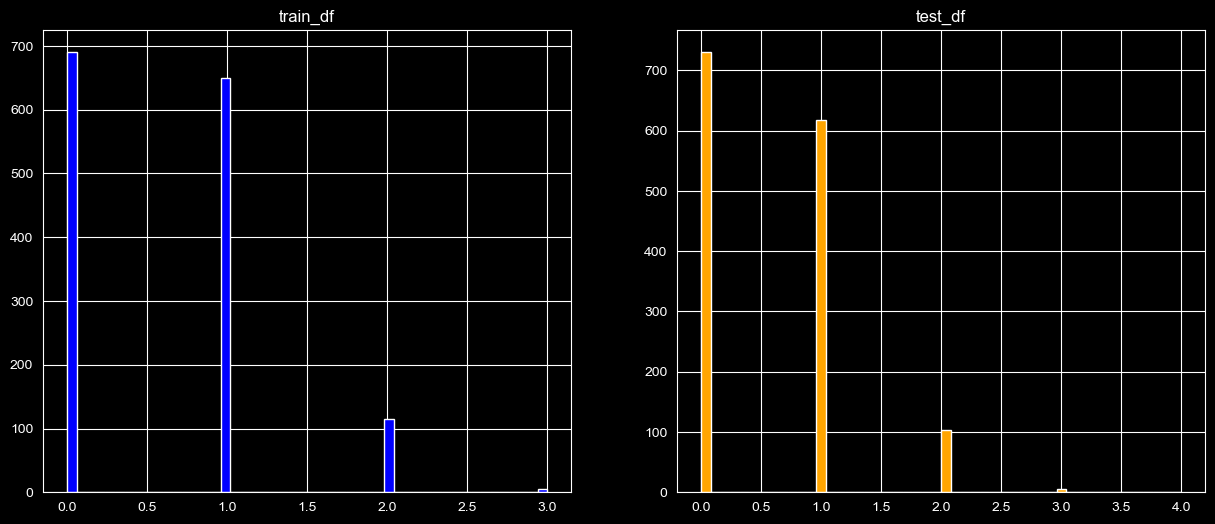

GarageYrBlt
                  train_df      test_df
count          1460.000000  1459.000000
mean           1976.507534  1976.000000
std              26.306739    27.761773
min            1872.000000  1890.000000
25%            1959.000000  1958.000000
50%            1978.000000  1978.000000
75%            2001.000000  2002.000000
max            2010.000000  2207.000000
per missing       0.000000     0.000000
numb outliers     2.000000     3.000000


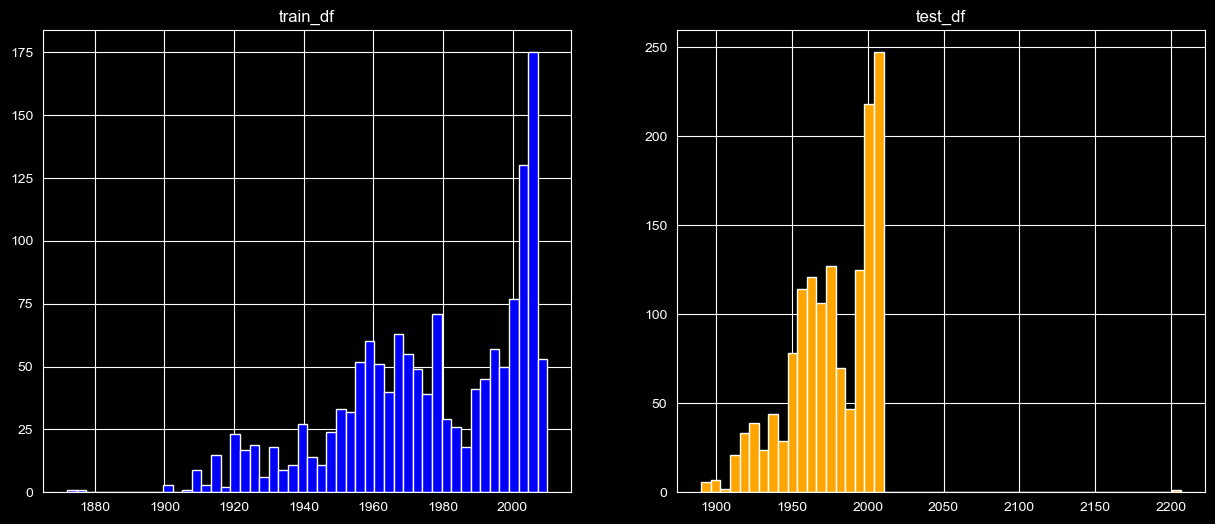

GarageCars
                  train_df      test_df
count          1460.000000  1459.000000
mean              1.767123     1.766278
std               0.747315     0.775703
min               0.000000     0.000000
25%               1.000000     1.000000
50%               2.000000     2.000000
75%               2.000000     2.000000
max               4.000000     5.000000
per missing       0.000000     0.000000
numb outliers     5.000000    12.000000


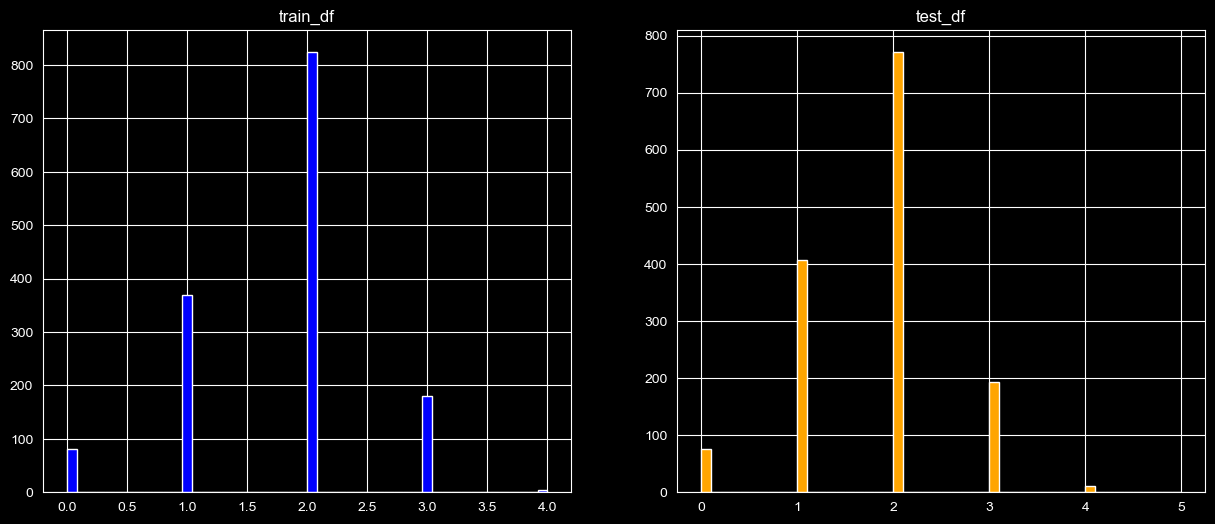

GarageArea
                  train_df      test_df
count          1460.000000  1459.000000
mean            472.980137   472.773818
std             213.804841   216.974247
min               0.000000     0.000000
25%             334.500000   318.000000
50%             480.000000   480.000000
75%             576.000000   576.000000
max            1418.000000  1488.000000
per missing       0.000000     0.000000
numb outliers    21.000000    21.000000


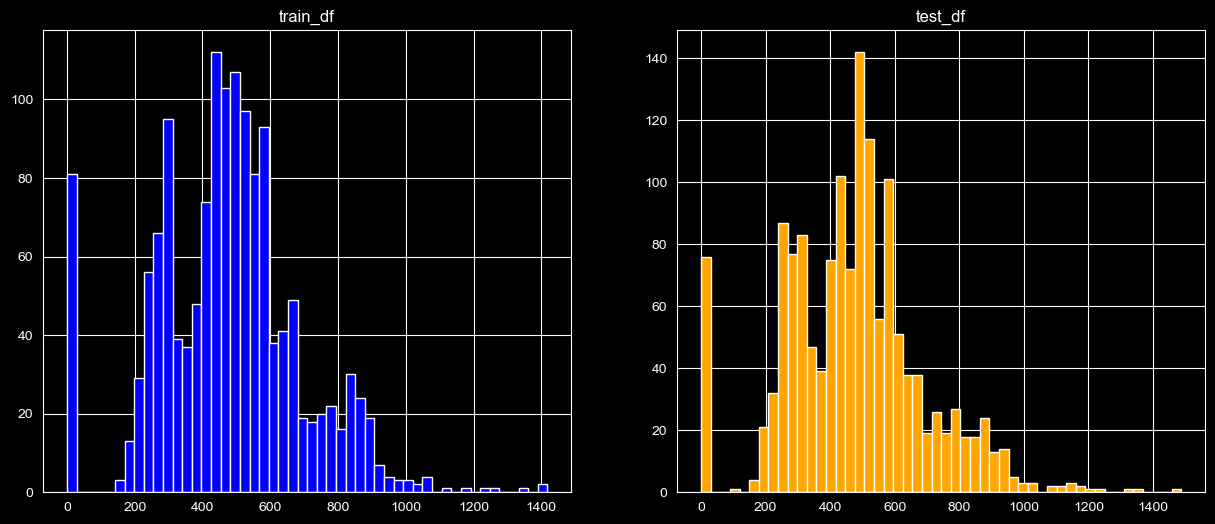

WoodDeckSF
                  train_df      test_df
count          1460.000000  1459.000000
mean             94.244521    93.174777
std             125.338794   127.744882
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%             168.000000   168.000000
max             857.000000  1424.000000
per missing       0.000000     0.000000
numb outliers    32.000000    35.000000


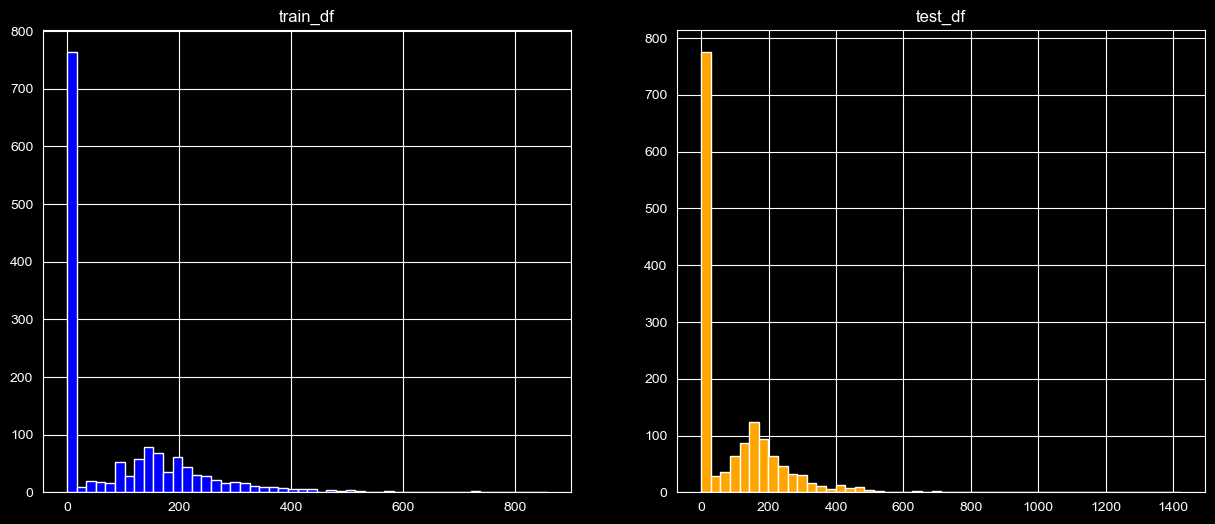

OpenPorchSF
                  train_df      test_df
count          1460.000000  1459.000000
mean             46.660274    48.313914
std              66.256028    68.883364
min               0.000000     0.000000
25%               0.000000     0.000000
50%              25.000000    28.000000
75%              68.000000    72.000000
max             547.000000   742.000000
per missing       0.000000     0.000000
numb outliers    77.000000    79.000000


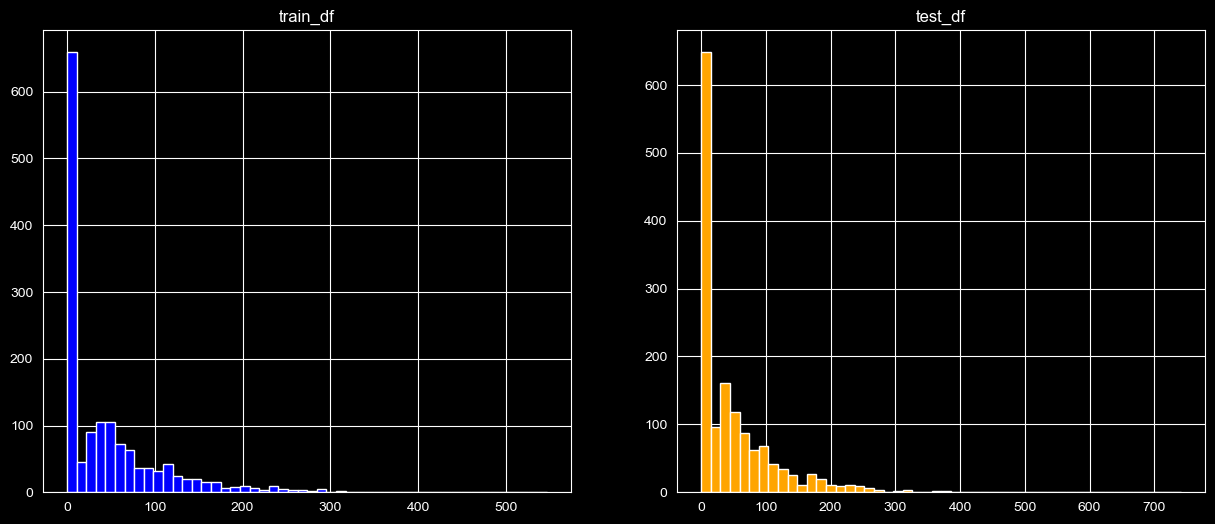

EnclosedPorch
                  train_df      test_df
count          1460.000000  1459.000000
mean             21.954110    24.243317
std              61.119149    67.227765
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             552.000000  1012.000000
per missing       0.000000     0.000000
numb outliers   208.000000   251.000000


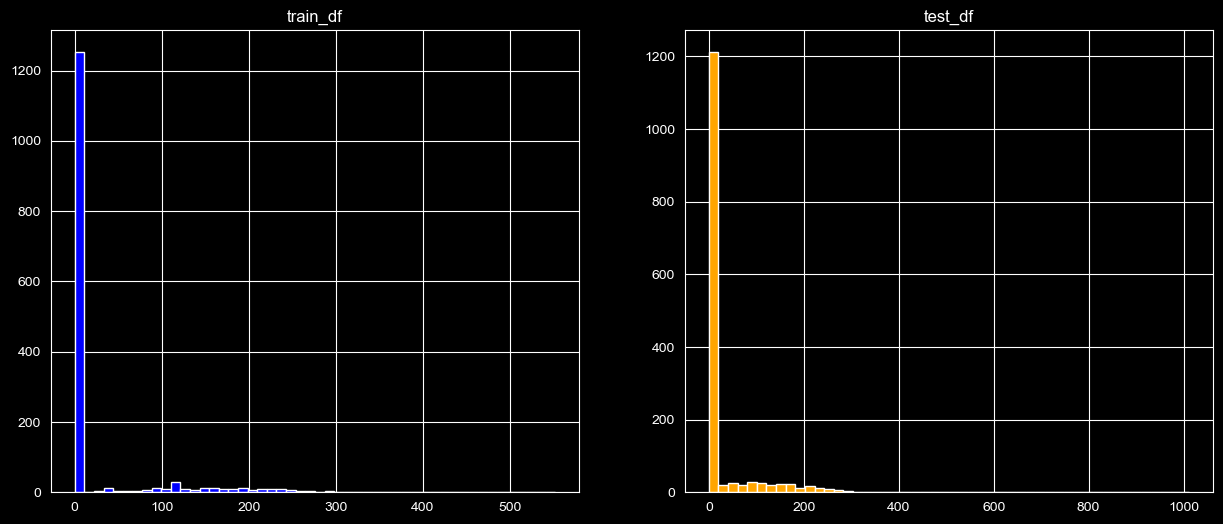

3SsnPorch
                  train_df      test_df
count          1460.000000  1459.000000
mean              3.409589     1.794380
std              29.317331    20.207842
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             508.000000   360.000000
per missing       0.000000     0.000000
numb outliers    24.000000    13.000000


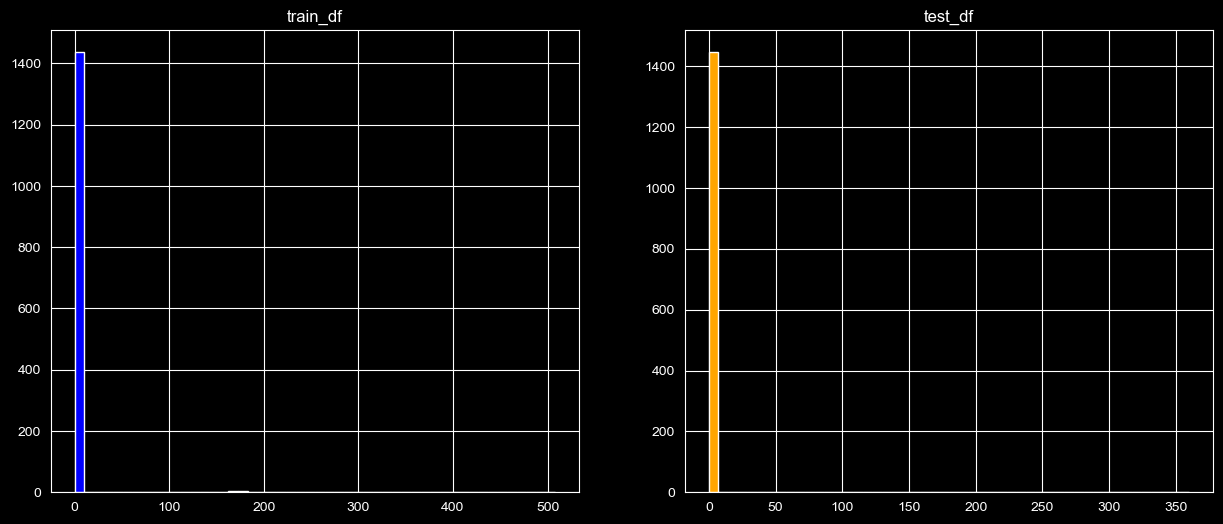

ScreenPorch
                  train_df      test_df
count          1460.000000  1459.000000
mean             15.060959    17.064428
std              55.757415    56.609763
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             480.000000   576.000000
per missing       0.000000     0.000000
numb outliers   116.000000   140.000000


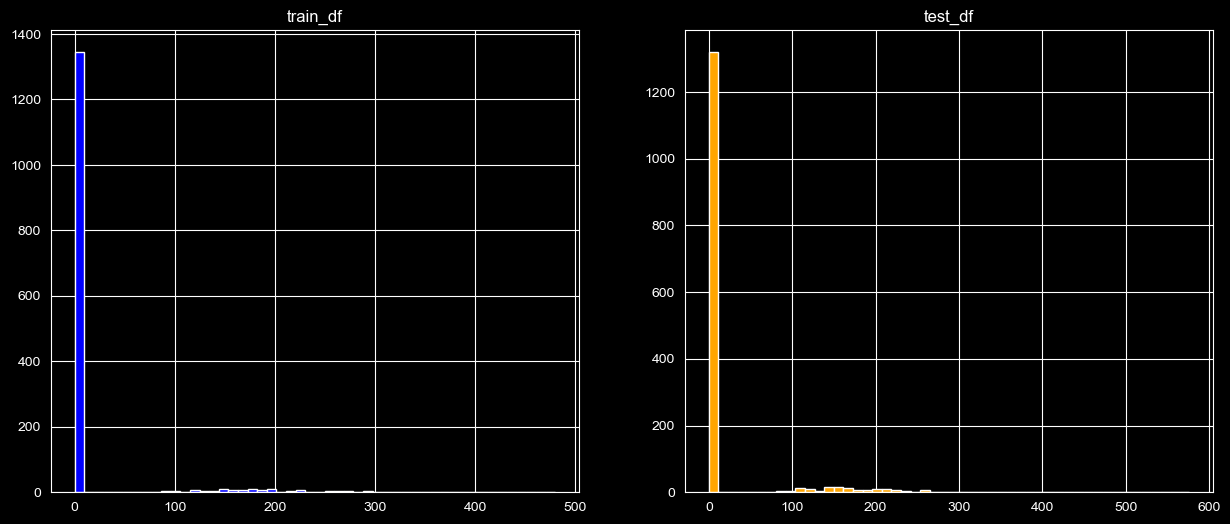

PoolArea
                  train_df      test_df
count          1460.000000  1459.000000
mean              2.758904     1.744345
std              40.177307    30.491646
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             738.000000   800.000000
per missing       0.000000     0.000000
numb outliers     7.000000     6.000000


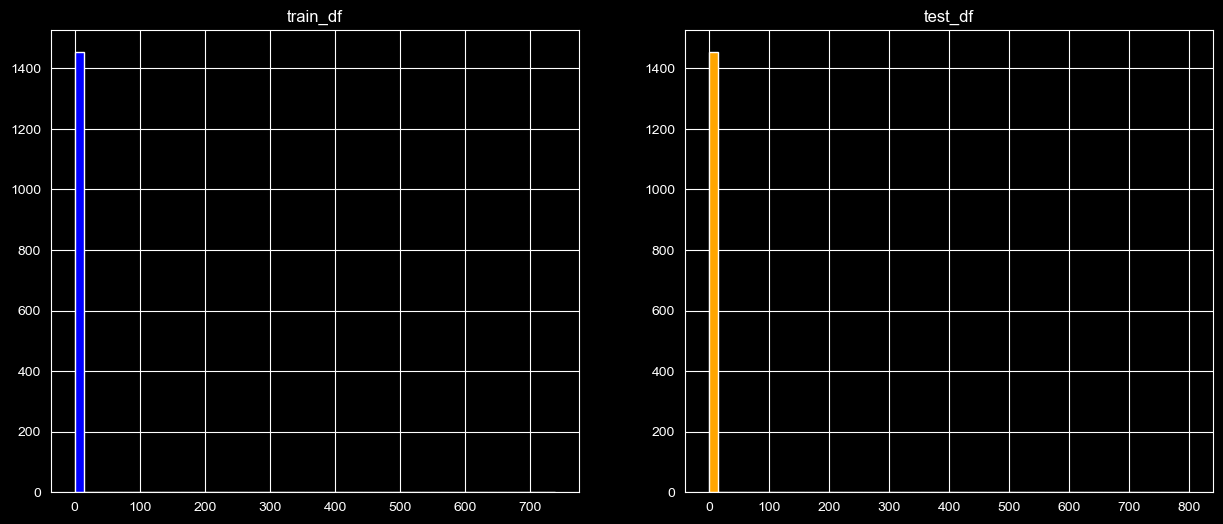

MiscVal
                   train_df       test_df
count           1460.000000   1459.000000
mean              43.489041     58.167923
std              496.123024    630.806978
min                0.000000      0.000000
25%                0.000000      0.000000
50%                0.000000      0.000000
75%                0.000000      0.000000
max            15500.000000  17000.000000
per missing        0.000000      0.000000
numb outliers     52.000000     51.000000


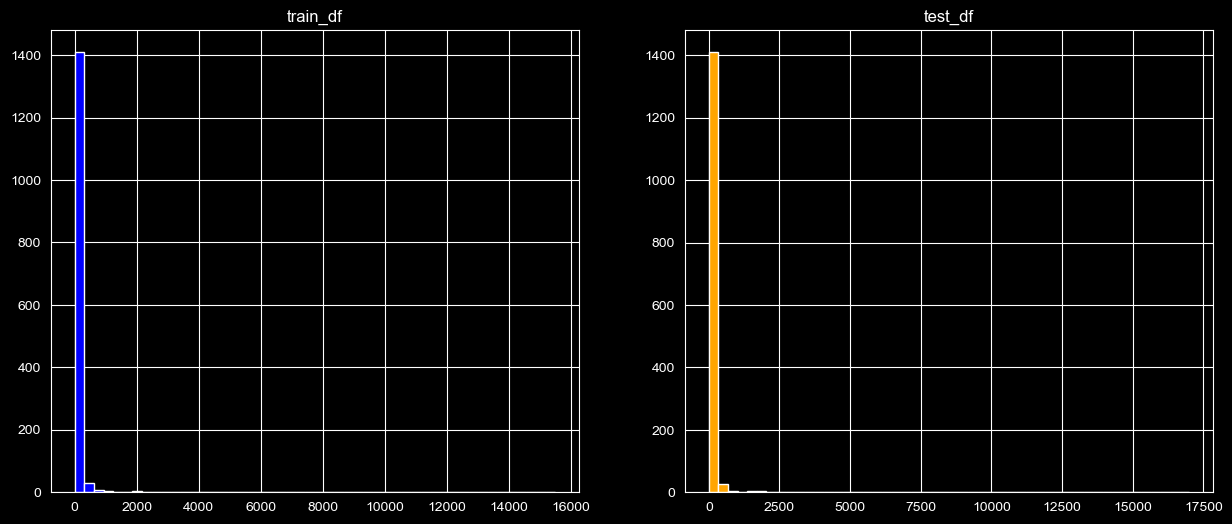

MoSold
                  train_df      test_df
count          1460.000000  1459.000000
mean              6.321918     6.104181
std               2.703626     2.722432
min               1.000000     1.000000
25%               5.000000     4.000000
50%               6.000000     6.000000
75%               8.000000     8.000000
max              12.000000    12.000000
per missing       0.000000     0.000000
numb outliers     0.000000     0.000000


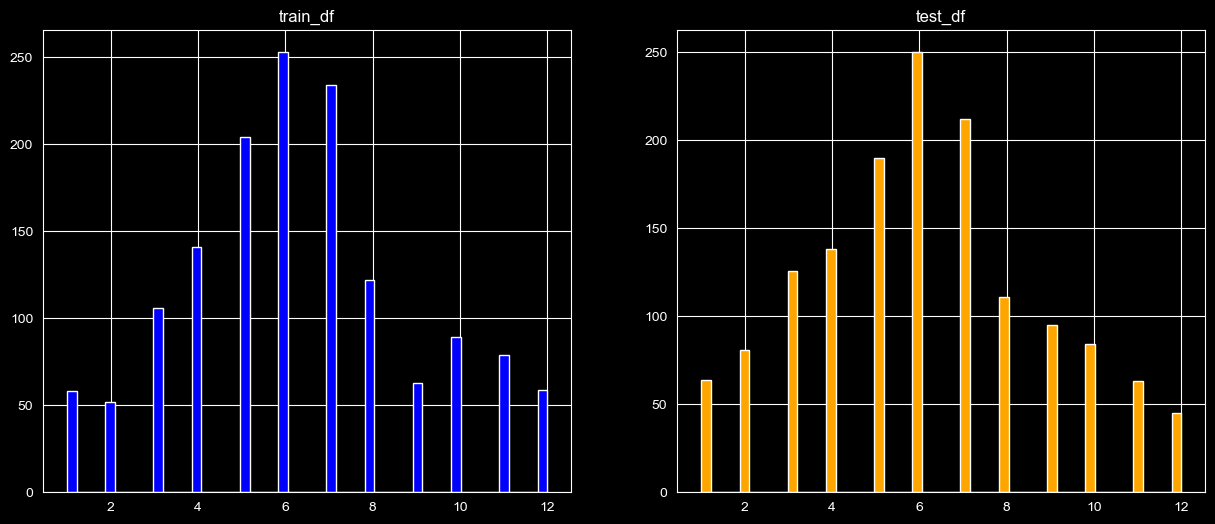

YrSold
                  train_df      test_df
count          1460.000000  1459.000000
mean           2007.815753  2007.769705
std               1.328095     1.301740
min            2006.000000  2006.000000
25%            2007.000000  2007.000000
50%            2008.000000  2008.000000
75%            2009.000000  2009.000000
max            2010.000000  2010.000000
per missing       0.000000     0.000000
numb outliers     0.000000     0.000000


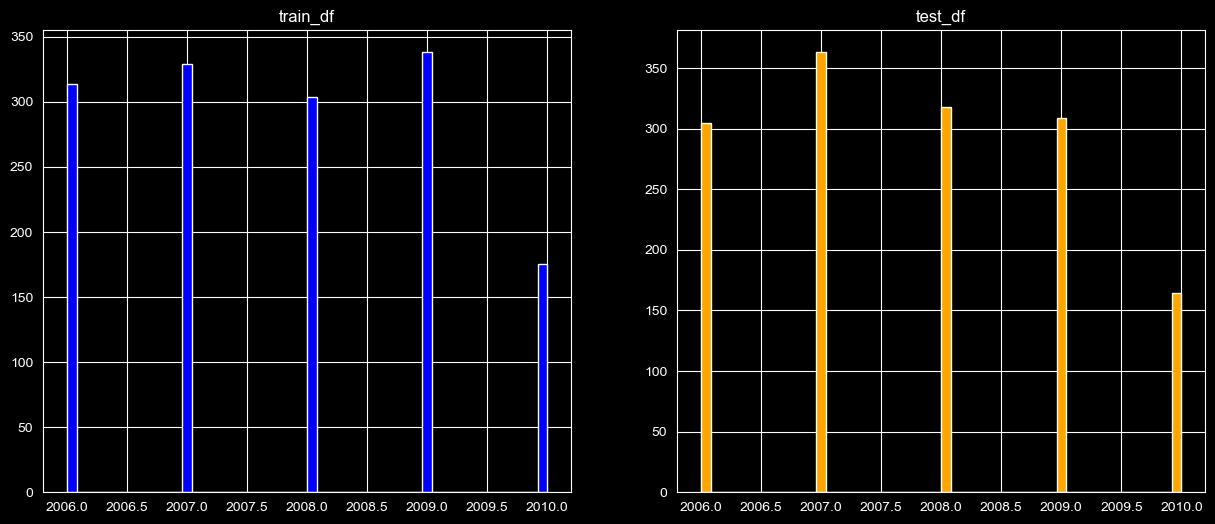

In [1188]:
for num_col in num_cols:
    print(num_col)
    print(describe_col(num_col))
    plot_multi_hist(train_df, test_df, num_col, 'train_df', 'test_df', bins=50)

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:35:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:35:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:35:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:35:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mean: 0.14512897262673163
Std: 0.014453048159338842


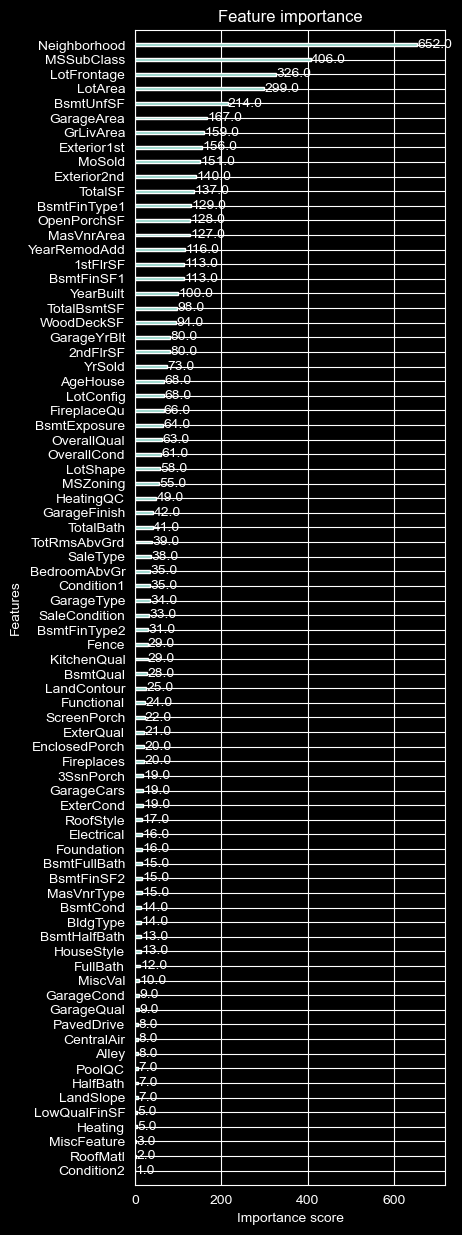

In [1189]:
X = train_df.drop(columns=['SalePrice'])
y = np.log1p(train_df['SalePrice'])

X[cat_cols] = X[cat_cols].astype('category')
test_df[cat_cols] = test_df[cat_cols].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

params = {
    "objective": "reg:squarederror",
    "seed": RANDOM_STATE,
    'enable_categorical': True,
    'early_stopping': 20,
    'n_estimators': 1000,
    'eval_metric': 'rmse'
}


cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rsme_vals = []
test_preds = []
for train_idx, valid_idx in cv.split(X, y):
    model = xgb.XGBRegressor(**params)
    model.fit(
        X.iloc[train_idx], y.iloc[train_idx],
        eval_set=[(X.iloc[valid_idx], y.iloc[valid_idx])],
        verbose=False
    )
    preds = model.predict(X.iloc[valid_idx])
    rsme_vals.append(np.sqrt(mean_squared_error(y.iloc[valid_idx], preds)))
    prediction = model.predict(test_df.drop(columns=['Id']))
    test_preds.append(prediction)
print("Mean:", np.mean(rsme_vals))
print("Std:", np.std(rsme_vals))


fig, ax = plt.subplots(figsize=(4, 15))
xgb.plot_importance(model, ax=ax)
plt.show()

In [1190]:
test_preds = np.column_stack(test_preds)
final_pred = test_preds.mean(axis=1)
print(final_pred)
# Build submission
submission = pd.DataFrame({
    'Id': test_df['Id'].values,
    'SalePrice': np.exp(final_pred)
})

out_path = "submission.csv"
submission.to_csv(out_path, index=False)

[11.686155  11.953393  12.174687  ... 11.8993435 11.709592  12.214028 ]


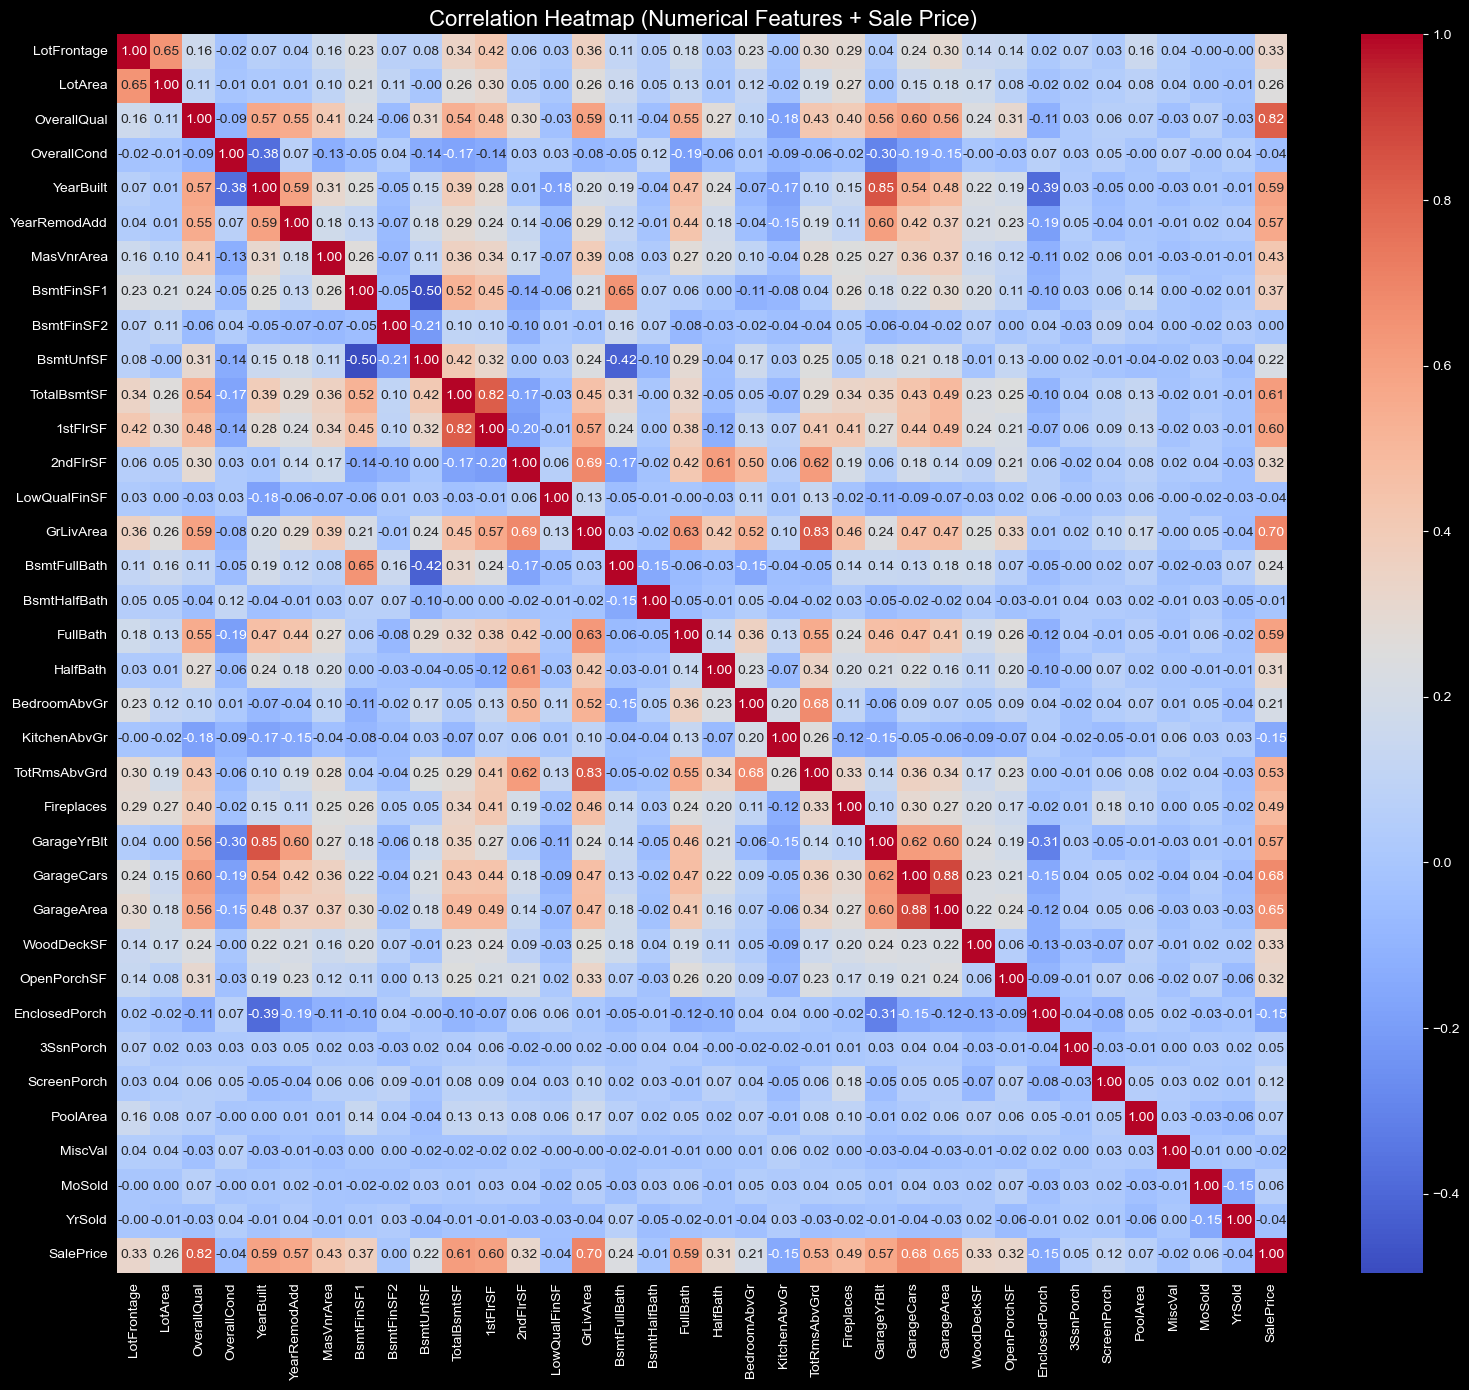

In [1191]:
# Compute correlation matrix
corr_matrix = pd.concat([X[num_cols], y],axis=1).corr()


# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap (Numerical Features + Sale Price)', fontsize=16)
plt.tight_layout()
plt.show()

In [1192]:
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtQual'].isnull().sum())
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtCond'].isnull().sum())
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtExposure'].isnull().sum())
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtFinType1'].isnull().sum())
print(train_df[train_df['BsmtFinSF2'] != 0]['BsmtFinType2'].isnull().sum())

0
0
0
0
0


In [1193]:
print(train_df['MasVnrType'].value_counts(dropna=False))

MasVnrType
BrkFace    1317
Stone       128
BrkCmn       15
Name: count, dtype: int64


<Axes: xlabel='LotConfig', ylabel='LotFrontage'>

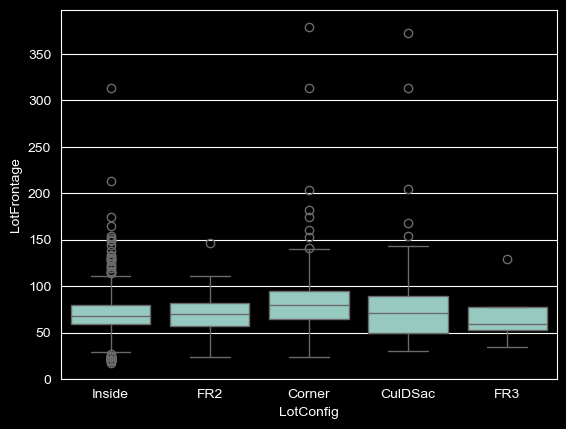

In [1194]:
sns.boxplot(x='LotConfig', y='LotFrontage', data=train_df, orient='v')


<Axes: xlabel='LotShape', ylabel='LotFrontage'>

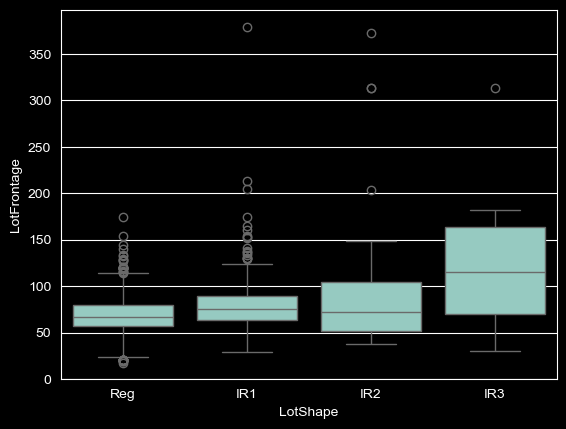

In [1195]:
sns.boxplot(x='LotShape', y='LotFrontage', data=train_df, orient='v')